In [1]:
from qtpg.team import Team
from qtpg.learner import Learner
from qtpg.program import Program
from qtpg.rule import Rule
from qtpg.figure13 import Figure13
from qtpg.figure13_hole_in_wall import Figure13HoleInWall
from qtpg.figure12 import Figure12
from qtpg.figure9 import Figure9
from qtpg.figureRandom import FigureRandom
from qtpg.figureHeywood import FigureHeywood
from qtpg.search_manager import SearchManager
import numpy as np
import uuid
import copy
import matplotlib.pyplot as plt

In [2]:
gp_query_env = 0
gp_query_runs = []

In [3]:
# env params
memorySize = 40
legalMove = 0.1
illegalMove = -0.01
outOfBounds = 0.0
memoryRepeat = -0.01
# memoryRepeat = 0.0
goalReached = 100

# envName = 'Figure 13'
# env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 13 Hole in Wall'
# env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 12'
# env = Figure12(5, 5, (4, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Figure 9'
# env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# envName = 'Heywood'
# env = FigureHeywood(10, 10, (4, 4), (0, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
envName = 'Random'
env = FigureRandom(20, 20, memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
env.shake(0.2)

Rows: 20
Columns: 20
Start State: (5, 14)
Win State: (16, 13)
Illegal States: [(0, 14), (17, 3), (11, 6), (6, 15), (18, 6), (8, 5), (13, 10), (12, 14), (13, 4), (8, 1), (14, 17), (19, 2), (18, 2), (7, 15), (13, 13), (0, 7), (3, 8), (4, 12), (12, 11), (16, 1), (11, 14), (5, 0), (1, 1), (13, 6), (16, 2), (19, 10), (12, 9), (14, 14), (16, 6), (12, 13), (16, 9), (16, 12), (15, 7), (9, 4), (14, 15), (1, 2), (4, 17), (4, 2), (11, 16), (2, 13), (17, 6), (1, 5), (3, 6), (8, 8), (9, 19), (7, 9), (14, 12), (9, 18), (7, 5), (11, 19), (4, 7), (3, 18), (19, 18), (7, 3), (4, 6), (10, 18), (11, 3), (16, 4), (13, 18), (4, 15), (13, 16), (0, 13), (6, 17), (1, 17), (5, 15), (1, 14), (18, 4), (10, 6), (16, 15), (1, 7), (18, 16), (10, 8), (10, 9), (17, 19), (16, 0), (12, 2), (17, 5), (15, 18), (8, 13), (14, 4)]
matlab code, converted so plus one to everything
GW.CurrentState = '[15,15]';
GW.TerminalStates = '[4,14]';
GW.ObstacleStates = ["[20,15]";"[3,4]";"[9,7]";"[14,16]";"[2,7]";"[12,6]";"[7,11]";"[8,15

In [4]:
# env.save()

In [5]:
# env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
import random
# new start-goal parameter generator... might want to put this in .env file, where a new id gets generated...
new_start = (0, 0)
new_goal = (0, 0)

while new_start == (0, 0) or new_start in env.illegal_states:
    new_start = (random.randint(0, env.rows-1), random.randint(0, env.cols-1))

while new_goal == (0, 0) or new_goal in env.illegal_states:
    new_goal = (random.randint(0, env.rows-1), random.randint(0, env.cols-1))
    
print(f'New start: {new_start}')
print(f'New goal: {new_goal}')

New start: (7, 8)
New goal: (4, 8)


In [6]:
# envName = ''
envName = '20x20#1sg#2'
# 20x20 #1
# start-goal #1 for 20x20 #1 --> default load
if envName == '20x20#1sg#1':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51')
# start-goal #2 for 20x20 #1
elif envName == '20x20#1sg#2':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (15, 15)
    env.current_state = env.start_state
    env.win_state = (3, 8)
    env.display()
# start-goal #3 for 20x20 #2
elif envName == '20x20#1sg#3':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (12, 19)
    env.current_state = env.start_state
    env.win_state = (9, 13)
    env.display()
elif envName == '20x20#1sg#4':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (15, 17)
    env.current_state = env.start_state
    env.win_state = (0, 15)
    env.display()
elif envName == '20x20#1sg#5':
    env.load('592726fe-a9e1-46fc-99c3-fc97ffeb4b51', False)
    env.start_state = (15, 11)
    env.current_state = env.start_state
    env.win_state = (10, 7)
    env.display()
elif envName == '20x20#2sg#1':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301')
elif envName == '20x20#2sg#2':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (10, 2)
    env.current_state = env.start_state
    env.win_state = (6, 18)
    env.display()
elif envName == '20x20#2sg#3':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (0, 15)
    env.current_state = env.start_state
    env.win_state = (14, 0)
    env.display()
elif envName == '20x20#2sg#4':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (9, 4)
    env.current_state = env.start_state
    env.win_state = (15, 0)
    env.display()
elif envName == '20x20#2sg#5':
    env.load('00840a8c-af04-4a3e-b427-451ab41f3301', False)
    env.start_state = (14, 16)
    env.current_state = env.start_state
    env.win_state = (8, 5)
    env.display()
elif envName == '20x20#3sg#1':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f')
elif envName == '20x20#3sg#2':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (7, 9)
    env.current_state = env.start_state
    env.win_state = (17, 10)
    env.display()
elif envName == '20x20#3sg#3':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (3, 2)
    env.current_state = env.start_state
    env.win_state = (0, 14)
    env.display()
elif envName == '20x20#3sg#4':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (0, 13)
    env.current_state = env.start_state
    env.win_state = (15, 18)
    env.display()
elif envName == '20x20#3sg#5':
    env.load('2ca23d5d-788e-44df-9ca1-96b18b9c223f', False)
    env.start_state = (1, 8)
    env.current_state = env.start_state
    env.win_state = (3, 14)
    env.display()
# 50x50s
elif envName == '50x50#1sg#1':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694')
elif envName == '50x50#1sg#2':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (16, 46)
    env.current_state = env.start_state
    env.win_state = (20, 1)
    env.display()
elif envName == '50x50#1sg#3':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (3, 12)
    env.current_state = env.start_state
    env.win_state = (14, 43)
    env.display()
elif envName == '50x50#1sg#4':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (37, 17)
    env.current_state = env.start_state
    env.win_state = (20, 46)
    env.display()
elif envName == '50x50#1sg#5':
    env.load('f5e46ad0-c274-415c-b831-7b1893ea9694', False)
    env.start_state = (20, 11)
    env.current_state = env.start_state
    env.win_state = (42, 25)
    env.display()

Loading env...
Env loaded successfully!
Rows: 20
Columns: 20
Start State: (15, 15)
Win State: (3, 8)
Illegal States: [(14, 4), (15, 18), (3, 3), (18, 2), (6, 11), (6, 4), (10, 6), (19, 10), (5, 2), (3, 4), (4, 1), (2, 10), (4, 10), (15, 2), (12, 13), (6, 15), (13, 4), (6, 8), (9, 6), (16, 10), (19, 5), (19, 2), (16, 0), (15, 8), (7, 11), (18, 5), (19, 12), (0, 17), (15, 19), (18, 19), (0, 18), (6, 1), (18, 4), (9, 18), (17, 15), (2, 6), (5, 1), (8, 18), (18, 12), (15, 4), (4, 2), (11, 5), (2, 3), (3, 19), (0, 11), (2, 18), (13, 18), (12, 6), (18, 17), (12, 5), (14, 17), (19, 9), (10, 18), (1, 4), (10, 13), (5, 19), (5, 3), (6, 18), (11, 10), (12, 3), (7, 14), (0, 7), (0, 8), (7, 0), (9, 5), (8, 7), (0, 6), (17, 3), (19, 4), (12, 12), (15, 14), (18, 11), (9, 16), (18, 0), (3, 16), (9, 3), (10, 17), (10, 15), (2, 1), (2, 2)]
matlab code, converted so plus one to everything
GW.CurrentState = '[5,16]';
GW.TerminalStates = '[17,9]';
GW.ObstacleStates = ["[6,5]";"[5,19]";"[17,4]";"[2,3]";"[1

In [7]:
numGens = 200
# maxTeamPool = 2
maxTeamPool = 1
runs = 10
# init search manager and starting teams

# searchManager = SearchManager(maxTeamPool)

# variables for tracking fitness, for curves
scores = []
gens = []
maxes = []
averages = []
mins = []

run_winners = []
runs_score_track = []

for run in range(runs):
    gp_query_env = 0
    maxes = []
    averages = []
    mins = []
    gens = []
    print(run)
    # init everything for new run
    searchManager = SearchManager(maxTeamPool)
    
    adam_and_eve = []
    env.reset()
    init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
    init_team.init_search(env, [2, 3])
#     adam_and_eve.append(init_team)
#     init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
#     init_team.init_search(env, [0, 1])
    adam_and_eve.append(init_team)
    win = False
    for adam in adam_and_eve:
        data = [adam, win]
        searchManager.evaluate_team(data)
    
    
    average_coverage = 0.0
    gen = 0
    for gen in range(numGens):
#     while (average_coverage < 0.7) and (len(searchManager.winners) < maxTeamPool):
#         print(average_coverage)
#         print('winners so far:')
#         print(searchManager.winners)
        print(f'GEN --> {gen}')
        gen += 1
        toEvaluateAfterGen = []
        scores = []
        # get it started
        for parent in searchManager.teamPool:
            # only run if the team has not yet won
            if parent not in searchManager.winners:
                env.current_state = parent.start_state

                # make offspring from parent, then let that offspring make a new rule
                child = copy.deepcopy(parent)
                child.gp_query_env = parent.gp_query_env # probably don't need this, can test later
                child.id = uuid.uuid4()
                win = child.search_no_back_track(env)
                
                if child.mostRecent.program.rule.region[3] - child.mostRecent.program.rule.region[2] >= 0:
                    gp_query_env += (child.mostRecent.program.rule.region[3] - child.mostRecent.program.rule.region[2]) + 1
                toEvaluateAfterGen.append([child, win])
                scores.append(child)
            else:
                scores.append(parent)

        for data in toEvaluateAfterGen:
            searchManager.evaluate_team(data)
        # start: manage fitness curves (at end of gen)
        gens.append(gen)
        total = 0
        max_fitness = -100
        min_fitness = 100

        for team in scores:
            total += team.fitness
            if team.fitness > max_fitness:
                max_fitness = team.fitness
            if team.fitness < min_fitness:
                min_fitness = team.fitness
        average_fitness = total / len(searchManager.teamPool)
        maxes.append(max_fitness)
        averages.append(average_fitness)
        mins.append(min_fitness)
        
        # find average region coverage
        total_coverage = 0.0
        for team in searchManager.teamPool:
            total_coverage += team.coverage([env.rows, env.cols], env.illegal_states)
        average_coverage = total_coverage / len(searchManager.teamPool)

    runs_score_track.append({'run': run, 'maxes': maxes, 'averages': averages, 'mins': mins})
    
    run_winners.append({'run': run, 'winners': searchManager.winners})
    gp_query_runs.append(gp_query_env)

0
GEN --> 0
------
11
[1, 15, 11, 16]
------
[1, 15, 11, 16]
GEN --> 1
------
24
[0, 13, 5, 17]
------
[0, 13, 5, 17]
GEN --> 2
------
18
[1, 7, 9, 19]
------
[1, 7, 9, 19]
GEN --> 3
------
19
[0, 17, 4, 14]
------
[0, 17, 4, 14]
GEN --> 4
------
6
[1, 14, 16, 19]
------
[1, 14, 16, 19]
GEN --> 5
------
13
[0, 19, 13, 19]
------
[0, 19, 13, 19]
GEN --> 6
------
8
[1, 14, 16, 19]
------
[1, 14, 16, 19]
GEN --> 7
------
6
[0, 18, 13, 16]
------
[0, 18, 13, 16]
GEN --> 8
------
4
[1, 15, 18, 19]
------
[1, 15, 18, 19]
GEN --> 9
------
10
[0, 19, 13, 19]
------
[0, 19, 13, 19]
GEN --> 10
------
4
[1, 15, 18, 19]
------
[1, 15, 18, 19]
GEN --> 11
------
12
[0, 19, 13, 19]
------
[0, 19, 13, 19]
GEN --> 12
------
5
[1, 18, 16, 19]
------
[1, 18, 16, 19]
GEN --> 13
------
11
[0, 16, 11, 19]
------
[0, 16, 11, 19]
GEN --> 14
------
12
[1, 15, 11, 16]
------
[1, 15, 11, 16]
GEN --> 15
------
16
[0, 13, 5, 17]
------
[0, 13, 5, 17]
GEN --> 16
------
6
[1, 5, 13, 17]
------
[1, 5, 13, 17]
GEN -->

------
3
[1, 18, 11, 12]
------
[1, 18, 11, 12]
GEN --> 143
------
11
[0, 12, 14, 19]
------
[0, 12, 14, 19]
GEN --> 144
------
13
[1, 16, 10, 19]
------
[1, 16, 10, 19]
GEN --> 145
------
9
[0, 12, 14, 19]
------
[0, 12, 14, 19]
GEN --> 146
------
16
[1, 19, 6, 14]
------
[1, 19, 6, 14]
GEN --> 147
no steps!
------
2
[0, 8, 19, 19]
------
[0, 8, 19, 19]
GEN --> 148
------
4
[0, 14, 18, 19]
------
[0, 14, 18, 19]
GEN --> 149
------
18
[1, 19, 6, 14]
------
[1, 19, 6, 14]
GEN --> 150
------
7
[0, 12, 14, 19]
------
[0, 12, 14, 19]
GEN --> 151
------
4
[1, 18, 11, 12]
------
[1, 18, 11, 12]
GEN --> 152
------
17
[0, 11, 11, 19]
------
[0, 11, 11, 19]
GEN --> 153
------
3
[1, 18, 11, 12]
------
[1, 18, 11, 12]
GEN --> 154
------
11
[0, 12, 14, 19]
------
[0, 12, 14, 19]
GEN --> 155
------
5
[1, 17, 11, 13]
------
[1, 17, 11, 13]
GEN --> 156
------
12
[0, 11, 11, 19]
------
[0, 11, 11, 19]
GEN --> 157
------
12
[1, 15, 11, 16]
------
[1, 15, 11, 16]
GEN --> 158
------
23
[0, 14, 5, 16]
---

------
8
[1, 15, 0, 5]
------
[1, 15, 0, 5]
GEN --> 98
------
8
[0, 3, 8, 15]
------
[0, 3, 8, 15]
GEN --> 99
GEN --> 100
GEN --> 101
GEN --> 102
GEN --> 103
GEN --> 104
GEN --> 105
GEN --> 106
GEN --> 107
GEN --> 108
GEN --> 109
GEN --> 110
GEN --> 111
GEN --> 112
GEN --> 113
GEN --> 114
GEN --> 115
GEN --> 116
GEN --> 117
GEN --> 118
GEN --> 119
GEN --> 120
GEN --> 121
GEN --> 122
GEN --> 123
GEN --> 124
GEN --> 125
GEN --> 126
GEN --> 127
GEN --> 128
GEN --> 129
GEN --> 130
GEN --> 131
GEN --> 132
GEN --> 133
GEN --> 134
GEN --> 135
GEN --> 136
GEN --> 137
GEN --> 138
GEN --> 139
GEN --> 140
GEN --> 141
GEN --> 142
GEN --> 143
GEN --> 144
GEN --> 145
GEN --> 146
GEN --> 147
GEN --> 148
GEN --> 149
GEN --> 150
GEN --> 151
GEN --> 152
GEN --> 153
GEN --> 154
GEN --> 155
GEN --> 156
GEN --> 157
GEN --> 158
GEN --> 159
GEN --> 160
GEN --> 161
GEN --> 162
GEN --> 163
GEN --> 164
GEN --> 165
GEN --> 166
GEN --> 167
GEN --> 168
GEN --> 169
GEN --> 170
GEN --> 171
GEN --> 172
GEN --> 173
GE

------
13
[1, 13, 0, 9]
------
[1, 13, 0, 9]
GEN --> 55
------
5
[0, 6, 12, 14]
------
[0, 6, 12, 14]
GEN --> 56
------
19
[1, 12, 0, 11]
------
[1, 12, 0, 11]
GEN --> 57
------
6
[0, 6, 12, 14]
------
[0, 6, 12, 14]
GEN --> 58
------
19
[1, 12, 0, 11]
------
[1, 12, 0, 11]
GEN --> 59
------
24
[0, 5, 4, 18]
------
[0, 5, 4, 18]
GEN --> 60
------
4
[1, 4, 4, 5]
------
[1, 4, 4, 5]
GEN --> 61
------
9
[0, 4, 3, 9]
------
[0, 4, 3, 9]
GEN --> 62
------
1
[1, 8, 3, 4]
------
[1, 8, 3, 4]
GEN --> 63
GEN --> 64
GEN --> 65
GEN --> 66
GEN --> 67
GEN --> 68
GEN --> 69
GEN --> 70
GEN --> 71
GEN --> 72
GEN --> 73
GEN --> 74
GEN --> 75
GEN --> 76
GEN --> 77
GEN --> 78
GEN --> 79
GEN --> 80
GEN --> 81
GEN --> 82
GEN --> 83
GEN --> 84
GEN --> 85
GEN --> 86
GEN --> 87
GEN --> 88
GEN --> 89
GEN --> 90
GEN --> 91
GEN --> 92
GEN --> 93
GEN --> 94
GEN --> 95
GEN --> 96
GEN --> 97
GEN --> 98
GEN --> 99
GEN --> 100
GEN --> 101
GEN --> 102
GEN --> 103
GEN --> 104
GEN --> 105
GEN --> 106
GEN --> 107
GEN -->

------
12
[0, 16, 11, 19]
------
[0, 16, 11, 19]
GEN --> 113
------
7
[1, 12, 13, 17]
------
[1, 12, 13, 17]
GEN --> 114
------
7
[0, 15, 9, 13]
------
[0, 15, 9, 13]
GEN --> 115
------
8
[1, 12, 13, 17]
------
[1, 12, 13, 17]
GEN --> 116
------
7
[0, 15, 9, 13]
------
[0, 15, 9, 13]
GEN --> 117
------
10
[1, 13, 13, 19]
------
[1, 13, 13, 19]
GEN --> 118
------
14
[0, 19, 13, 19]
------
[0, 19, 13, 19]
GEN --> 119
------
3
[1, 15, 18, 19]
------
[1, 15, 18, 19]
GEN --> 120
------
10
[0, 19, 13, 19]
------
[0, 19, 13, 19]
GEN --> 121
no steps!
------
2
[1, 17, 19, 19]
------
[1, 17, 19, 19]
GEN --> 122
------
3
[1, 15, 18, 19]
------
[1, 15, 18, 19]
GEN --> 123
------
12
[0, 19, 13, 19]
------
[0, 19, 13, 19]
GEN --> 124
------
5
[1, 18, 16, 19]
------
[1, 18, 16, 19]
GEN --> 125
no steps!
------
2
[0, 18, 18, 18]
------
[0, 18, 18, 18]
GEN --> 126
no steps!
------
2
[0, 18, 18, 18]
------
[0, 18, 18, 18]
GEN --> 127
------
13
[0, 19, 13, 19]
------
[0, 19, 13, 19]
GEN --> 128
------
5

------
8
[0, 10, 0, 5]
------
[0, 10, 0, 5]
GEN --> 59
no steps!
------
2
[1, 5, 10, 10]
------
[1, 5, 10, 10]
GEN --> 60
------
14
[1, 0, 8, 15]
------
[1, 0, 8, 15]
GEN --> 61
------
4
[0, 9, 0, 2]
------
[0, 9, 0, 2]
GEN --> 62
------
13
[1, 2, 6, 14]
------
[1, 2, 6, 14]
GEN --> 63
------
10
[0, 10, 0, 5]
------
[0, 10, 0, 5]
GEN --> 64
------
23
[1, 1, 7, 19]
------
[1, 1, 7, 19]
GEN --> 65
------
5
[0, 17, 0, 2]
------
[0, 17, 0, 2]
GEN --> 66
------
24
[1, 1, 7, 19]
------
[1, 1, 7, 19]
GEN --> 67
------
5
[0, 12, 0, 2]
------
[0, 12, 0, 2]
GEN --> 68
------
13
[1, 0, 8, 15]
------
[1, 0, 8, 15]
GEN --> 69
------
8
[0, 14, 0, 3]
------
[0, 14, 0, 3]
GEN --> 70
------
6
[1, 3, 13, 16]
------
[1, 3, 13, 16]
GEN --> 71
------
8
[0, 13, 0, 3]
------
[0, 13, 0, 3]
GEN --> 72
------
17
[1, 2, 6, 14]
------
[1, 2, 6, 14]
GEN --> 73
------
4
[0, 6, 2, 3]
------
[0, 6, 2, 3]
GEN --> 74
------
10
[1, 2, 6, 14]
------
[1, 2, 6, 14]
GEN --> 75
------
7
[0, 14, 0, 3]
------
[0, 14, 0, 3]
GEN

------
13
[0, 2, 11, 17]
------
[0, 2, 11, 17]
GEN --> 40
------
6
[1, 16, 0, 2]
------
[1, 16, 0, 2]
GEN --> 41
------
27
[0, 1, 5, 19]
------
[0, 1, 5, 19]
GEN --> 42
no steps!
------
2
[1, 18, 1, 1]
------
[1, 18, 1, 1]
GEN --> 43
no steps!
------
2
[1, 6, 1, 1]
------
[1, 6, 1, 1]
GEN --> 44
------
12
[1, 13, 0, 9]
------
[1, 13, 0, 9]
GEN --> 45
------
24
[0, 1, 5, 19]
------
[0, 1, 5, 19]
GEN --> 46
------
3
[1, 8, 1, 3]
------
[1, 8, 1, 3]
GEN --> 47
GEN --> 48
GEN --> 49
GEN --> 50
GEN --> 51
GEN --> 52
GEN --> 53
GEN --> 54
GEN --> 55
GEN --> 56
GEN --> 57
GEN --> 58
GEN --> 59
GEN --> 60
GEN --> 61
GEN --> 62
GEN --> 63
GEN --> 64
GEN --> 65
GEN --> 66
GEN --> 67
GEN --> 68
GEN --> 69
GEN --> 70
GEN --> 71
GEN --> 72
GEN --> 73
GEN --> 74
GEN --> 75
GEN --> 76
GEN --> 77
GEN --> 78
GEN --> 79
GEN --> 80
GEN --> 81
GEN --> 82
GEN --> 83
GEN --> 84
GEN --> 85
GEN --> 86
GEN --> 87
GEN --> 88
GEN --> 89
GEN --> 90
GEN --> 91
GEN --> 92
GEN --> 93
GEN --> 94
GEN --> 95
GEN --> 96

------
4
[1, 17, 11, 13]
------
[1, 17, 11, 13]
GEN --> 68
------
12
[0, 11, 11, 19]
------
[0, 11, 11, 19]
GEN --> 69
------
13
[1, 12, 0, 11]
------
[1, 12, 0, 11]
GEN --> 70
------
10
[0, 0, 12, 16]
------
[0, 0, 12, 16]
GEN --> 71
------
6
[1, 16, 0, 2]
------
[1, 16, 0, 2]
GEN --> 72
------
27
[0, 1, 5, 19]
------
[0, 1, 5, 19]
GEN --> 73
------
13
[1, 14, 0, 6]
------
[1, 14, 0, 6]
GEN --> 74
------
8
[0, 0, 12, 16]
------
[0, 0, 12, 16]
GEN --> 75
------
12
[1, 15, 0, 5]
------
[1, 15, 0, 5]
GEN --> 76
------
7
[0, 3, 8, 15]
------
[0, 3, 8, 15]
GEN --> 77
GEN --> 78
GEN --> 79
GEN --> 80
GEN --> 81
GEN --> 82
GEN --> 83
GEN --> 84
GEN --> 85
GEN --> 86
GEN --> 87
GEN --> 88
GEN --> 89
GEN --> 90
GEN --> 91
GEN --> 92
GEN --> 93
GEN --> 94
GEN --> 95
GEN --> 96
GEN --> 97
GEN --> 98
GEN --> 99
GEN --> 100
GEN --> 101
GEN --> 102
GEN --> 103
GEN --> 104
GEN --> 105
GEN --> 106
GEN --> 107
GEN --> 108
GEN --> 109
GEN --> 110
GEN --> 111
GEN --> 112
GEN --> 113
GEN --> 114
GEN --> 

In [8]:
#fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for average in averages:
#     y.append(average)
# plt.xlabel('Generation')
# plt.ylabel('Average Score')
# plt.plot(x, y)
# plt.show()

In [9]:
# #fitness curves
# x = []
# y = []
# for gen in gens:
#     x.append(gen)

# for max_ in maxes:
#     y.append(max_)
# plt.xlabel('Generation')
# plt.ylabel('Max Score')
# plt.plot(x, y)
# plt.show()

In [10]:
# for team in searchManager.winners:
#     print('$$$$$$$$$$$$$ winnnnnner start $$$$$$$$$$$$$$$$$$$$')
#     print(team.fitness)
#     print('Learners:')
#     for learner in team.learners:
#         print(f'Region: {learner.program.rule.region} --> Action: {learner.program.rule.action_set}')
#     print('$$$$$$$$$$$$$ winnnnnner end $$$$$$$$$$$$$$$$$$$$')

In [11]:
for team in searchManager.winners:
    # importing libraries
    from mpl_toolkits import mplot3d
    import numpy as np
    import matplotlib.pyplot as plt

    region_action_scores = []
    for learner in team.learners:
        if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
            region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
        else:
            region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

    sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
    # print(sorted_region_action_scores)
    # for record in sorted_region_action_scores:
    #     print(record)
    action_states = []
    for record in sorted_region_action_scores:
        action = ''
        if record['action'] == 0:
            action = '\u2191'
        elif record['action'] == 1:
            action = '\u2193'
        elif record['action'] == 2:
            action = '\u2192'
        elif record['action'] == 3:
            action = '\u2190'

        for i in range(record['region'][3] - record['region'][2]+1):
            state = [0, 0]
            state[record['region'][0]] = record['region'][1]
            state[not record['region'][0]] = record['region'][2] + i

            # ensure we do not enter duplicate states
            found = 0
            for pair in action_states:
                if pair['state'] == (state[0], state[1]):
                    found = 1

            if found == 0:
                action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

    # add in the rest of the states, either they are not visited, or illegal
#     for n in reversed(range(env.rows)):
#         for m in range(env.cols):
#             action = ''
#             found = 0
#             for record in action_states:
#                 if record['state'] == (n, m):
#                     found = 1
#                     action = record['action']
#     #                 action = float(round(record['q'], 0))
#             if found == 0:
#                 if not env.check_legal((n, m)):
#                     action = 'X'
#                 else:
#                     action = '?'
#             print(f'{action} ', end='')
#         print('\n')
#     print('------------NEW WINNER ----------------')

## Average Max Fitness Curves

In [12]:
print(runs_score_track[0]['maxes'][0])
print(len(runs_score_track))
print(len(runs_score_track[0]))
print(len(runs_score_track[0]['maxes']))

1.03
10
4
200


In [13]:
# #fitness curves
# x = []
# y = []
# average_maxes = np.zeros(numGens)
# # average_maxes = np.zeros(100)

# for i in range(len(gens)):
#     for q in range(len(runs_score_track)):
#         average_maxes[i] += runs_score_track[q]['maxes'][i]
#     average_maxes[i] /= len(runs_score_track)
    
# for gen in gens:
#     x.append(gen)

# plt.title(f'Average max score over {len(runs_score_track)} runs for {envName}')
# plt.xlabel('Generation')
# plt.ylabel('Average Max Score')
# plt.plot(x, average_maxes)
# plt.show()

## Reinforcement Learning + Victory Lap

In [14]:
# print(run_winners)
# for winner in run_winners[0]['winners']:
#     for learner in winner.learners:
#         print(learner.program.rule.region)
#     print('\n\n\n')
# for learner in team.learners:
#     print(learner.program.rule.region)

In [15]:
# for i in range(len(run_winners[0]['winners'])):
#     for learner in run_winners[0]['winners'][i].learners:
#         print(learner.id)
#     print('\n')

In [16]:
# team = searchManager.winners[0]



# team = run_winners[0]['winners'][0]
stuck_count = 0
for run in range(runs):
    for team in run_winners[run]['winners']:
        stuck_count = 0
        print('NEW CHAMPION!')
        print(f'Run: {run}')
        print(f'Winner: {team.id}')
        team.discount = 0.9
        team.alpha = 0.5
        # for learner in team.learners:
        #     print(learner.program.rule.region)

        # team.prune_single_cell_regions() # don't think this is good...
        team.prune_duplicate_regions()

        # illegal_states = [(2, 0), (2, 1), (3, 1), (1, 3), (2, 3), (3, 3), (1, 4)]
        illegal_states = env.illegal_states
        dimensions = [env.rows, env.cols]

        print(env.start_state)
        print(env.win_state)
        for i in range(env.rows):
        #     print(f'Epoch: {i+1} --------')
        #     env.reset()
            current_state = env.start_state
#             print(f'curr -> {env.current_state}')
            win = False
            selected_learner = team.select_learner(current_state, [0, 0, 0, 0])
            while not win and stuck_count < 15:
#             while not win:
        #         win, needs_update, reward, winning_action = team.q_evaluation(env, selected_learner)
                if selected_learner is None:
                    stuck_count += 1
                    print('nnone!-0')
                else:
                    win, needs_update, reward, winning_action, current_state = team.q_evaluation(current_state, selected_learner, illegal_states, dimensions)
                    if not win:
                        selected_learner = team.select_learner(current_state, selected_learner.program.rule.region)
                        if selected_learner is None:
                            print('none!?')
                            stuck_count += 1
                        else:
                            team.transition_update(reward, winning_action, needs_update, selected_learner)
                            stuck_count = 0

            team.final_update(reward, winning_action, needs_update)
        print(win)
        for learner in team.learners:
            print(f'{learner.program.rule.region}')
            for i in range(len(learner.program.rule.action_set)):
                  print(f'{learner.program.rule.action_set[i]} --> {learner.program.rule.value_set[i]}')

NEW CHAMPION!
Run: 0
Winner: 06462ee4-29c4-44c9-8ba7-77b90fd9cc89
(15, 15)
(3, 8)
(15, 15)
(13, 15)
(13, 6)
(19, 6)
(14, 6)
(14, 14)
(14, 9)
(5, 9)
(18, 9)
(18, 6)
(19, 6)
(13, 6)
(14, 6)
(14, 9)
(14, 8)
(10, 8)
(10, 11)
(17, 11)
(17, 7)
(17, 9)
(17, 7)
(15, 7)
(11, 7)
(11, 9)
(12, 9)
(4, 9)
(4, 7)
(7, 7)
(2, 7)
(2, 9)
(12, 9)
(5, 9)
(5, 7)
(5, 13)
(6, 13)
(9, 13)
(0, 13)
(9, 13)
(0, 13)
(9, 13)
(0, 13)
(6, 13)
(9, 13)
(9, 12)
(9, 13)
(9, 12)
(3, 12)
(11, 12)
(10, 12)
(11, 12)
(11, 14)
(11, 19)
(11, 14)
(11, 15)
(11, 18)
(11, 19)
(11, 11)
(11, 18)
(11, 15)
(11, 18)
(11, 19)
(11, 15)
(11, 19)
(11, 16)
(11, 12)
(11, 19)
(11, 15)
(11, 14)
(11, 11)
(11, 15)
(11, 19)
(11, 18)
(11, 17)
(12, 17)
(11, 17)
(11, 19)
(11, 11)
(11, 18)
(11, 16)
(11, 18)
(11, 11)
(11, 19)
(12, 19)
(7, 19)
(12, 19)
(7, 19)
(14, 19)
(7, 19)
(14, 19)
(7, 19)
(7, 15)
(7, 16)
(7, 15)
(9, 15)
(9, 12)
(9, 10)
(10, 10)
(10, 11)
(14, 11)
(14, 13)
(14, 8)
(14, 14)
(11, 14)
(11, 12)
(11, 11)
(11, 16)
(11, 15)
(11, 17)
(11, 11

(13, 1)
(13, 2)
(13, 0)
(13, 2)
(13, 0)
(13, 2)
(11, 2)
(11, 3)
(11, 1)
(13, 1)
(13, 0)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(13, 2)
(13, 0)
(10, 0)
(10, 2)
(11, 2)
(9, 2)
(7, 2)
(12, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(11, 2)
(11, 1)
(13, 1)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(9, 1)
(9, 2)
(11, 2)
(9, 2)
(7, 2)
(12, 2)
(7, 2)
(11, 2)
(9, 2)
(9, 1)
(9, 2)
(11, 2)
(12, 2)
(9, 2)
(13, 2)
(13, 3)
(13, 2)
(11, 2)
(7, 2)
(11, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 2)
(12, 2)
(13, 2)
(9, 2)
(13, 2)
(11, 2)
(9, 2)
(12, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(11, 2)
(11, 3)
(10, 3)
(10, 2)
(9, 2)
(12, 2)
(11, 2)
(9, 2)
(13, 2)
(11, 2)
(13, 2)
(13, 0)
(13, 3)
(13, 0)
(13, 2)
(9, 2)
(7, 2)
(9, 2)
(12, 2)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(11, 2)
(12, 2)
(13, 2)
(9, 2)
(12, 2)
(13, 2)
(9, 2)
(7, 2)
(12, 2)
(9, 2)
(9, 1)
(9, 2)
(12,

(9, 1)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(11, 2)
(12, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 3)
(13, 0)
(10, 0)
(10, 2)
(13, 2)
(13, 3)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(9, 1)
(9, 2)
(13, 2)
(13, 3)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(7, 2)
(7, 6)
(5, 6)
(5, 7)
(2, 7)
(2, 9)
(18, 9)
(5, 9)
(5, 7)
(5, 13)
(5, 7)
(7, 7)
(7, 4)
(11, 4)
(11, 3)
(10, 3)
(10, 2)
(10, 4)
(10, 2)
(10, 4)
(10, 2)
(10, 4)
(11, 4)
(11, 1)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 2)
(13, 3)
(13, 2)
(11, 2)
(9, 2)
(12, 2)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 0)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 0)
(10, 0)
(10, 2)
(12, 2)
(7, 2)
(7, 6)
(7, 4)
(10, 4)
(10, 2)
(9, 2)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(11, 2)
(7, 2)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(12, 2)
(13, 2)
(11, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(11, 2)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(7, 2)
(11, 2)
(11, 3)
(11, 1)
(11, 3)
(11, 1)
(11, 3)
(11, 1)
(11, 3)
(11, 1)
(13, 1)
(13, 2)
(11, 2)
(11, 1)
(9

(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(13, 2)
(11, 2)
(11, 1)
(13, 1)
(13, 3)
(13, 0)
(13, 2)
(9, 2)
(13, 2)
(9, 2)
(13, 2)
(12, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(13, 2)
(13, 0)
(13, 2)
(13, 3)
(13, 0)
(13, 2)
(13, 0)
(13, 3)
(13, 2)
(13, 0)
(13, 2)
(7, 2)
(7, 4)
(10, 4)
(10, 2)
(7, 2)
(11, 2)
(7, 2)
(7, 4)
(10, 4)
(11, 4)
(10, 4)
(10, 2)
(11, 2)
(9, 2)
(7, 2)
(9, 2)
(13, 2)
(13, 3)
(13, 0)
(13, 2)
(9, 2)
(13, 2)
(9, 2)
(7, 2)
(11, 2)
(12, 2)
(9, 2)
(12, 2)
(9, 2)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 2)
(12, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 2)
(9, 2)
(7, 2)
(7, 4)
(10, 4)
(10, 2)
(9, 2)
(13, 2)
(9, 2)
(12, 2)
(9, 2)
(7, 2)
(11, 2)
(9, 2)
(12, 2)
(9, 2)
(12, 2)
(9, 2)
(7, 2)
(12, 2)
(7, 2)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(7, 2)
(7, 4)
(10, 4)
(10, 2)
(9, 2)
(12, 2)
(11, 2)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(7, 2)
(7, 6)
(5, 6)
(5, 7)
(2, 7)
(7, 7)
(7, 4)
(7, 6)
(7, 4)
(10, 4)
(11, 4)
(11, 1)
(11, 3)
(10, 3)
(10, 4)
(10,

(11, 11)
(11, 14)
(11, 15)
(11, 14)
(11, 18)
(11, 16)
(11, 12)
(11, 11)
(11, 16)
(12, 16)
(12, 19)
(7, 19)
(12, 19)
(7, 19)
(14, 19)
(12, 19)
(7, 19)
(7, 15)
(7, 16)
(4, 16)
(4, 11)
(4, 13)
(9, 13)
(6, 13)
(0, 13)
(9, 13)
(9, 12)
(3, 12)
(11, 12)
(11, 18)
(11, 12)
(11, 18)
(11, 15)
(11, 17)
(11, 16)
(11, 15)
(11, 14)
(11, 18)
(11, 11)
(11, 16)
(11, 11)
(11, 19)
(11, 12)
(11, 18)
(12, 18)
(12, 19)
(12, 16)
(11, 16)
(12, 16)
(12, 19)
(7, 19)
(12, 19)
(7, 19)
(7, 16)
(4, 16)
(4, 13)
(6, 13)
(6, 12)
(11, 12)
(11, 11)
(11, 17)
(11, 16)
(11, 17)
(11, 19)
(11, 15)
(14, 15)
(14, 8)
(14, 14)
(14, 9)
(5, 9)
(5, 7)
(5, 13)
(5, 7)
(5, 13)
(6, 13)
(9, 13)
(0, 13)
(6, 13)
(6, 12)
(11, 12)
(11, 18)
(11, 16)
(11, 18)
(11, 15)
(11, 11)
(11, 15)
(11, 14)
(11, 19)
(11, 15)
(11, 19)
(11, 15)
(11, 11)
(17, 11)
(17, 14)
(18, 14)
(18, 15)
(19, 15)
(19, 14)
(19, 18)
(19, 16)
(12, 16)
(12, 19)
(12, 17)
(12, 19)
(12, 18)
(11, 18)
(11, 16)
(12, 16)
(12, 19)
(11, 19)
(11, 17)
(11, 18)
(11, 17)
(11, 12)
(11, 19)
(

(9, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 0)
(13, 2)
(11, 2)
(9, 2)
(13, 2)
(7, 2)
(13, 2)
(7, 2)
(12, 2)
(9, 2)
(9, 1)
(9, 2)
(13, 2)
(13, 0)
(13, 3)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 0)
(10, 0)
(10, 4)
(11, 4)
(10, 4)
(10, 2)
(9, 2)
(11, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(7, 2)
(9, 2)
(11, 2)
(9, 2)
(12, 2)
(9, 2)
(13, 2)
(11, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(13, 2)
(13, 3)
(13, 2)
(13, 3)
(13, 0)
(13, 3)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(12, 2)
(11, 2)
(11, 3)
(10, 3)
(10, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(13, 2)
(13, 3)
(13, 2)
(13, 3)
(13, 0)
(10, 0)
(10, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 0)
(13, 3)
(13, 0)
(13, 2)
(9, 2)
(13, 2)
(7, 2)
(11, 2)
(11, 1)
(13, 1)
(9, 1)
(9, 2)
(11, 2)
(9, 2)
(13, 2)
(11, 2)
(9, 2)
(7, 2)
(12, 2)
(9, 2)
(7, 2)
(13, 2)
(9, 2)
(12, 2)
(13, 2)
(12, 2)
(13, 2)
(11, 2)
(12, 2)
(9, 2)
(12, 2)
(11,

(19, 14)
(19, 15)
(19, 16)
(12, 16)
(12, 14)
(12, 19)
(12, 18)
(12, 16)
(16, 16)
(16, 15)
(14, 15)
(14, 8)
(14, 14)
(11, 14)
(11, 18)
(11, 15)
(11, 16)
(11, 11)
(11, 12)
(11, 15)
(11, 14)
(11, 11)
(11, 15)
(11, 16)
(12, 16)
(12, 19)
(7, 19)
(11, 19)
(11, 15)
(11, 18)
(11, 17)
(11, 18)
(11, 19)
(11, 18)
(11, 14)
(11, 11)
(11, 18)
(11, 17)
(11, 12)
(11, 16)
(11, 15)
(11, 11)
(17, 11)
(17, 12)
(16, 12)
(16, 15)
(13, 15)
(13, 6)
(13, 5)
(13, 6)
(19, 6)
(14, 6)
(14, 8)
(10, 8)
(10, 11)
(10, 12)
(10, 11)
(10, 12)
(11, 12)
(11, 18)
(11, 15)
(14, 15)
(11, 15)
(11, 18)
(11, 11)
(11, 18)
(11, 15)
(11, 18)
(11, 19)
(7, 19)
(7, 15)
(9, 15)
(9, 12)
(11, 12)
(10, 12)
(10, 11)
(17, 11)
(17, 7)
(17, 12)
(16, 12)
(16, 19)
(17, 19)
(17, 16)
(12, 16)
(12, 19)
(12, 14)
(12, 18)
(12, 16)
(12, 14)
(12, 19)
(12, 14)
(11, 14)
(11, 18)
(12, 18)
(12, 16)
(12, 14)
(12, 19)
(12, 18)
(12, 19)
(7, 19)
(7, 16)
(4, 16)
(4, 13)
(9, 13)
(9, 10)
(9, 13)
(9, 12)
(9, 13)
(9, 12)
(9, 10)
(10, 10)
(10, 11)
(14, 11)
(17, 11)

(11, 19)
(11, 14)
(11, 18)
(11, 17)
(11, 15)
(11, 18)
(11, 17)
(11, 18)
(12, 18)
(12, 14)
(12, 16)
(11, 16)
(11, 19)
(7, 19)
(12, 19)
(12, 17)
(11, 17)
(11, 19)
(11, 17)
(11, 15)
(13, 15)
(13, 6)
(13, 5)
(13, 7)
(13, 6)
(13, 12)
(13, 5)
(13, 6)
(14, 6)
(14, 8)
(14, 13)
(14, 8)
(10, 8)
(10, 12)
(11, 12)
(11, 19)
(11, 12)
(11, 15)
(11, 18)
(11, 16)
(11, 15)
(14, 15)
(11, 15)
(11, 18)
(12, 18)
(12, 14)
(12, 19)
(7, 19)
(12, 19)
(14, 19)
(7, 19)
(7, 16)
(7, 15)
(9, 15)
(9, 10)
(9, 12)
(9, 13)
(0, 13)
(9, 13)
(9, 12)
(11, 12)
(11, 19)
(11, 12)
(11, 18)
(11, 11)
(11, 15)
(11, 12)
(11, 19)
(11, 16)
(12, 16)
(12, 19)
(7, 19)
(12, 19)
(12, 17)
(12, 19)
(12, 18)
(11, 18)
(11, 11)
(11, 17)
(12, 17)
(12, 18)
(12, 19)
(11, 19)
(11, 17)
(11, 19)
(11, 16)
(12, 16)
(12, 19)
(12, 14)
(12, 19)
(12, 18)
(12, 14)
(12, 18)
(12, 19)
(12, 18)
(12, 14)
(12, 19)
(7, 19)
(14, 19)
(11, 19)
(11, 14)
(11, 19)
(14, 19)
(12, 19)
(12, 14)
(11, 14)
(11, 15)
(11, 18)
(11, 17)
(11, 15)
(11, 19)
(11, 15)
(11, 18)
(11, 19

(12, 19)
(12, 14)
(9, 14)
(11, 14)
(11, 19)
(12, 19)
(12, 16)
(12, 17)
(12, 14)
(12, 16)
(12, 14)
(12, 17)
(12, 14)
(11, 14)
(11, 12)
(11, 18)
(11, 15)
(13, 15)
(13, 12)
(16, 12)
(16, 15)
(11, 15)
(11, 19)
(11, 11)
(11, 15)
(11, 11)
(11, 16)
(11, 11)
(11, 16)
(11, 19)
(11, 17)
(11, 14)
(11, 18)
(11, 17)
(11, 14)
(11, 11)
(11, 15)
(11, 17)
(11, 15)
(13, 15)
(11, 15)
(11, 12)
(11, 15)
(11, 16)
(11, 18)
(11, 19)
(11, 18)
(12, 18)
(12, 19)
(14, 19)
(11, 19)
(11, 11)
(17, 11)
(17, 12)
(16, 12)
(16, 19)
(16, 13)
(16, 19)
(17, 19)
(17, 16)
(12, 16)
(12, 18)
(12, 17)
(12, 14)
(12, 19)
(7, 19)
(7, 16)
(4, 16)
(4, 13)
(0, 13)
(6, 13)
(9, 13)
(6, 13)
(9, 13)
(9, 10)
(9, 13)
(9, 12)
(9, 10)
(10, 10)
(10, 11)
(10, 12)
(3, 12)
(10, 12)
(10, 11)
(17, 11)
(17, 7)
(17, 12)
(17, 9)
(17, 12)
(16, 12)
(16, 19)
(16, 15)
(16, 13)
(16, 15)
(11, 15)
(11, 18)
(12, 18)
(12, 14)
(9, 14)
(11, 14)
(11, 18)
(11, 17)
(11, 19)
(11, 14)
(11, 19)
(11, 18)
(11, 19)
(7, 19)
(7, 15)
(7, 16)
(7, 15)
(7, 16)
(7, 15)
(9, 15)

(14, 14)
(14, 9)
(18, 9)
(5, 9)
(5, 7)
(7, 7)
(7, 6)
(7, 4)
(7, 6)
(7, 4)
(10, 4)
(10, 2)
(11, 2)
(13, 2)
(13, 3)
(13, 2)
(12, 2)
(9, 2)
(7, 2)
(7, 4)
(7, 6)
(5, 6)
(5, 7)
(2, 7)
(2, 9)
(18, 9)
(12, 9)
(12, 10)
(13, 10)
(13, 6)
(13, 5)
(13, 7)
(13, 6)
(19, 6)
(19, 7)
(15, 7)
(11, 7)
(11, 9)
(5, 9)
(18, 9)
(18, 6)
(14, 6)
(14, 14)
(9, 14)
(9, 12)
(11, 12)
(11, 11)
(11, 18)
(11, 16)
(11, 19)
(11, 16)
(11, 19)
(11, 18)
(11, 19)
(11, 15)
(11, 19)
(7, 19)
(12, 19)
(7, 19)
(12, 19)
(12, 16)
(16, 16)
(16, 19)
(16, 15)
(11, 15)
(11, 18)
(11, 15)
(11, 17)
(11, 12)
(11, 19)
(7, 19)
(12, 19)
(7, 19)
(14, 19)
(12, 19)
(12, 14)
(11, 14)
(9, 14)
(9, 12)
(11, 12)
(11, 18)
(11, 11)
(11, 15)
(11, 17)
(11, 19)
(7, 19)
(7, 15)
(9, 15)
(9, 13)
(9, 12)
(3, 12)
(11, 12)
(11, 19)
(11, 15)
(11, 16)
(11, 18)
(11, 19)
(11, 16)
(11, 15)
(11, 18)
(12, 18)
(11, 18)
(11, 11)
(11, 18)
(11, 19)
(11, 18)
(11, 19)
(11, 14)
(11, 16)
(11, 12)
(11, 11)
(11, 12)
(3, 12)
win!
(15, 15)
(11, 15)
(11, 11)
(17, 11)
(14, 11)
(14

(12, 16)
(12, 19)
(11, 19)
(11, 15)
(13, 15)
(13, 5)
(13, 6)
(14, 6)
(14, 13)
(14, 8)
(14, 14)
(14, 9)
(14, 13)
(14, 8)
(14, 9)
(14, 13)
(14, 9)
(14, 8)
(10, 8)
(10, 11)
(17, 11)
(17, 7)
(17, 14)
(19, 14)
(19, 16)
(19, 14)
(19, 18)
(16, 18)
(16, 15)
(14, 15)
(11, 15)
(11, 11)
(14, 11)
(14, 9)
(14, 8)
(14, 9)
(12, 9)
(4, 9)
(4, 4)
(4, 7)
(2, 7)
(7, 7)
(2, 7)
(7, 7)
(2, 7)
(7, 7)
(7, 6)
(5, 6)
(5, 13)
(5, 7)
(2, 7)
(7, 7)
(7, 6)
(7, 4)
(7, 6)
(7, 4)
(7, 6)
(5, 6)
(5, 13)
(9, 13)
(6, 13)
(9, 13)
(0, 13)
(9, 13)
(9, 12)
(9, 10)
(9, 13)
(9, 12)
(11, 12)
(11, 18)
(11, 12)
(3, 12)
win!
(15, 15)
(14, 15)
(13, 15)
(11, 15)
(11, 14)
(9, 14)
(11, 14)
(11, 16)
(11, 18)
(11, 12)
(11, 15)
(11, 18)
(11, 16)
(11, 19)
(7, 19)
(14, 19)
(7, 19)
(14, 19)
(11, 19)
(11, 18)
(11, 14)
(11, 19)
(11, 11)
(11, 14)
(11, 16)
(12, 16)
(12, 19)
(12, 18)
(12, 14)
(11, 14)
(11, 17)
(11, 16)
(11, 17)
(11, 11)
(11, 14)
(11, 11)
(11, 17)
(12, 17)
(12, 19)
(11, 19)
(14, 19)
(11, 19)
(11, 15)
(11, 17)
(11, 14)
(11, 12)
(11

(12, 16)
(12, 17)
(12, 19)
(11, 19)
(11, 15)
(13, 15)
(13, 12)
(16, 12)
(16, 15)
(13, 15)
(11, 15)
(13, 15)
(13, 7)
(13, 12)
(16, 12)
(16, 19)
(17, 19)
(17, 16)
(11, 16)
(11, 19)
(11, 16)
(11, 15)
(14, 15)
(13, 15)
(13, 12)
(13, 6)
(13, 5)
(13, 12)
(13, 6)
(13, 7)
(17, 7)
(17, 14)
(17, 7)
(15, 7)
(17, 7)
(17, 12)
(16, 12)
(16, 15)
(14, 15)
(14, 8)
(14, 13)
(14, 8)
(14, 9)
(4, 9)
(5, 9)
(18, 9)
(18, 6)
(19, 6)
(19, 7)
(11, 7)
(11, 9)
(4, 9)
(5, 9)
(5, 7)
(7, 7)
(7, 4)
(10, 4)
(10, 2)
(7, 2)
(12, 2)
(11, 2)
(9, 2)
(7, 2)
(9, 2)
(11, 2)
(9, 2)
(7, 2)
(7, 4)
(7, 6)
(7, 4)
(10, 4)
(11, 4)
(11, 1)
(9, 1)
(13, 1)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 0)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 3)
(13, 0)
(13, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 3)
(13, 2)
(11, 2)
(11, 3)
(10, 3)
(10, 2)
(11, 2)
(13, 2)
(9, 2)
(13, 2)
(9, 2)
(7, 2)
(9, 2)
(7, 2)
(11, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1

(13, 2)
(9, 2)
(12, 2)
(13, 2)
(13, 3)
(13, 0)
(13, 2)
(9, 2)
(7, 2)
(7, 4)
(10, 4)
(11, 4)
(10, 4)
(11, 4)
(11, 3)
(11, 1)
(9, 1)
(9, 2)
(13, 2)
(11, 2)
(11, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 3)
(13, 2)
(12, 2)
(11, 2)
(11, 3)
(10, 3)
(10, 2)
(10, 4)
(10, 2)
(9, 2)
(13, 2)
(9, 2)
(7, 2)
(7, 4)
(10, 4)
(11, 4)
(10, 4)
(11, 4)
(10, 4)
(10, 2)
(9, 2)
(12, 2)
(9, 2)
(12, 2)
(9, 2)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 3)
(13, 0)
(13, 3)
(13, 2)
(11, 2)
(11, 1)
(9, 1)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 3)
(13, 0)
(13, 2)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(13, 2)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(13, 0)
(13, 3)
(13, 0)
(13, 2)
(7, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 0)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(13, 3)
(13, 2)
(9, 2)
(13, 2)
(9, 2)
(12, 2)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 3)
(13, 0)
(13, 2)
(9, 2)
(13, 2)
(13, 3)
(13, 2)
(7, 2)
(13, 2)
(11, 2)
(11, 1)
(9, 1)
(13, 1)
(13, 

(4, 9)
(12, 9)
(4, 9)
(18, 9)
(18, 6)
(13, 6)
(14, 6)
(19, 6)
(14, 6)
(14, 9)
(14, 13)
(13, 13)
(13, 12)
(13, 6)
(19, 6)
(19, 7)
(17, 7)
(17, 12)
(16, 12)
(16, 15)
(16, 13)
(19, 13)
(19, 15)
(19, 18)
(19, 15)
(18, 15)
(19, 15)
(18, 15)
(19, 15)
(19, 16)
(19, 15)
(18, 15)
(19, 15)
(19, 18)
(19, 15)
(18, 15)
(19, 15)
(19, 16)
(19, 15)
(19, 16)
(12, 16)
(12, 18)
(11, 18)
(11, 15)
(11, 19)
(11, 16)
(11, 12)
(11, 11)
(14, 11)
(17, 11)
(17, 7)
(17, 12)
(17, 14)
(17, 9)
(17, 12)
(16, 12)
(16, 13)
(16, 15)
(14, 15)
(11, 15)
(13, 15)
(11, 15)
(11, 12)
(11, 14)
(11, 12)
(11, 15)
(11, 18)
(12, 18)
(11, 18)
(11, 19)
(11, 15)
(11, 19)
(11, 15)
(13, 15)
(11, 15)
(11, 18)
(11, 17)
(11, 15)
(14, 15)
(14, 13)
(14, 8)
(10, 8)
(10, 11)
(17, 11)
(17, 7)
(17, 14)
(19, 14)
(19, 15)
(19, 14)
(19, 15)
(19, 18)
(19, 15)
(19, 18)
(19, 15)
(19, 14)
(19, 16)
(19, 18)
(16, 18)
(16, 19)
(16, 13)
(16, 19)
(16, 15)
(14, 15)
(13, 15)
(13, 6)
(13, 12)
(16, 12)
(16, 15)
(16, 19)
(16, 15)
(11, 15)
(11, 12)
(11, 18)
(11, 

(19, 15)
(19, 14)
(19, 15)
(18, 15)
(19, 15)
(19, 16)
(12, 16)
(16, 16)
(16, 15)
(11, 15)
(11, 12)
(11, 14)
(11, 15)
(11, 12)
(11, 18)
(11, 17)
(11, 14)
(11, 17)
(11, 19)
(7, 19)
(11, 19)
(11, 12)
(11, 17)
(11, 15)
(11, 14)
(11, 19)
(11, 12)
(11, 18)
(12, 18)
(12, 19)
(11, 19)
(11, 17)
(11, 14)
(9, 14)
(11, 14)
(11, 11)
(11, 19)
(11, 15)
(11, 14)
(11, 15)
(11, 19)
(11, 15)
(14, 15)
(14, 14)
(14, 8)
(14, 13)
(14, 9)
(12, 9)
(5, 9)
(4, 9)
(18, 9)
(5, 9)
(18, 9)
(18, 6)
(19, 6)
(13, 6)
(13, 12)
(13, 6)
(13, 7)
(13, 12)
(13, 5)
(13, 6)
(19, 6)
(13, 6)
(13, 12)
(13, 6)
(14, 6)
(13, 6)
(13, 5)
(13, 12)
(13, 6)
(13, 7)
(11, 7)
(15, 7)
(17, 7)
(17, 14)
(17, 9)
(17, 7)
(11, 7)
(17, 7)
(17, 14)
(19, 14)
(19, 16)
(19, 15)
(19, 16)
(19, 15)
(19, 16)
(12, 16)
(12, 14)
(12, 16)
(12, 19)
(12, 18)
(11, 18)
(12, 18)
(11, 18)
(11, 17)
(11, 12)
(11, 18)
(12, 18)
(12, 19)
(12, 17)
(11, 17)
(11, 16)
(11, 18)
(11, 17)
(11, 11)
(11, 17)
(11, 18)
(11, 14)
(11, 11)
(11, 18)
(12, 18)
(12, 16)
(11, 16)
(11, 15)


(19, 16)
(19, 18)
(19, 14)
(18, 14)
(19, 14)
(18, 14)
(18, 15)
(19, 15)
(19, 18)
(16, 18)
(16, 19)
(16, 15)
(16, 13)
(16, 15)
(14, 15)
(14, 8)
(14, 13)
(14, 14)
(14, 13)
(14, 14)
(14, 13)
(13, 13)
(13, 6)
(14, 6)
(19, 6)
(14, 6)
(14, 14)
(14, 9)
(14, 14)
(11, 14)
(11, 17)
(11, 12)
(11, 14)
(11, 19)
(11, 14)
(11, 19)
(12, 19)
(7, 19)
(12, 19)
(12, 17)
(12, 14)
(11, 14)
(11, 15)
(11, 18)
(11, 19)
(11, 17)
(11, 14)
(11, 15)
(13, 15)
(13, 5)
(13, 7)
(13, 5)
(13, 6)
(14, 6)
(14, 9)
(12, 9)
(12, 10)
(13, 10)
(13, 7)
(13, 12)
(16, 12)
(16, 19)
(16, 15)
(14, 15)
(13, 15)
(13, 7)
(15, 7)
(17, 7)
(17, 14)
(19, 14)
(19, 16)
(19, 15)
(19, 14)
(19, 15)
(19, 18)
(19, 14)
(18, 14)
(18, 15)
(19, 15)
(19, 14)
(19, 16)
(11, 16)
(11, 14)
(11, 18)
(11, 11)
(17, 11)
(17, 14)
(18, 14)
(18, 15)
(19, 15)
(19, 16)
(19, 14)
(19, 16)
(12, 16)
(12, 14)
(12, 19)
(11, 19)
(11, 18)
(11, 14)
(11, 15)
(11, 12)
(11, 16)
(11, 14)
(11, 18)
(12, 18)
(12, 14)
(12, 16)
(12, 14)
(12, 19)
(11, 19)
(7, 19)
(11, 19)
(11, 16)
(1

(18, 9)
(4, 9)
(5, 9)
(18, 9)
(4, 9)
(4, 4)
(4, 7)
(7, 7)
(2, 7)
(7, 7)
(7, 4)
(10, 4)
(10, 2)
(7, 2)
(7, 6)
(5, 6)
(5, 13)
(6, 13)
(9, 13)
(0, 13)
(9, 13)
(0, 13)
(6, 13)
(9, 13)
(9, 12)
(11, 12)
(11, 14)
(9, 14)
(11, 14)
(11, 12)
(11, 16)
(11, 19)
(12, 19)
(12, 14)
(11, 14)
(11, 15)
(11, 19)
(11, 11)
(11, 14)
(11, 15)
(11, 12)
(11, 14)
(11, 12)
(11, 17)
(11, 16)
(11, 12)
(10, 12)
(10, 11)
(14, 11)
(17, 11)
(17, 14)
(17, 7)
(17, 9)
(18, 9)
(12, 9)
(18, 9)
(4, 9)
(5, 9)
(5, 7)
(5, 13)
(5, 7)
(7, 7)
(7, 4)
(11, 4)
(11, 1)
(13, 1)
(13, 3)
(13, 2)
(13, 3)
(13, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(9, 2)
(12, 2)
(13, 2)
(9, 2)
(7, 2)
(9, 2)
(9, 1)
(13, 1)
(13, 3)
(13, 0)
(13, 3)
(13, 2)
(13, 3)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(13, 2)
(13, 3)
(13, 2)
(9, 2)
(9, 1)
(9, 2)
(7, 2)
(7, 6)
(7, 4)
(10, 4)
(10, 2)
(10, 4)
(11, 4)
(11, 3)
(10, 3)
(10, 2)
(9, 2)
(7, 2)
(9, 2)
(11, 2)
(7, 2)
(9, 2)
(9, 1)
(9, 2)
(9, 1)
(13, 1)
(9, 1)
(13, 1)
(13, 3)
(13, 2)
(13, 0)
(13, 3)
(13, 2)
(11, 2

(13, 12)
(16, 12)
(16, 15)
(13, 15)
(13, 6)
(13, 7)
(11, 7)
(17, 7)
(17, 14)
(19, 14)
(18, 14)
(19, 14)
(19, 15)
(19, 18)
(19, 15)
(19, 16)
(19, 15)
(19, 14)
(18, 14)
(19, 14)
(19, 16)
(19, 14)
(19, 18)
(19, 14)
(19, 18)
(16, 18)
(16, 19)
(17, 19)
(17, 16)
(11, 16)
(11, 15)
(11, 19)
(12, 19)
(12, 16)
(12, 14)
(12, 17)
(12, 19)
(12, 17)
(12, 14)
(12, 18)
(12, 14)
(11, 14)
(11, 19)
(11, 18)
(12, 18)
(12, 19)
(12, 14)
(9, 14)
(11, 14)
(9, 14)
(9, 13)
(6, 13)
(9, 13)
(9, 12)
(11, 12)
(3, 12)
win!
(15, 15)
(13, 15)
(13, 12)
(13, 6)
(13, 12)
(13, 6)
(14, 6)
(14, 13)
(14, 8)
(14, 9)
(14, 14)
(9, 14)
(11, 14)
(11, 18)
(11, 12)
(11, 15)
(11, 11)
(11, 19)
(7, 19)
(12, 19)
(7, 19)
(12, 19)
(12, 17)
(12, 14)
(12, 19)
(12, 14)
(12, 19)
(7, 19)
(11, 19)
(7, 19)
(14, 19)
(7, 19)
(7, 15)
(7, 16)
(7, 15)
(9, 15)
(9, 10)
(9, 13)
(9, 10)
(9, 13)
(6, 13)
(9, 13)
(6, 13)
(0, 13)
(9, 13)
(9, 12)
(11, 12)
(11, 15)
(11, 11)
(14, 11)
(14, 13)
(14, 9)
(14, 14)
(9, 14)
(11, 14)
(11, 15)
(11, 16)
(16, 16)
(16, 15

1 --> 0.7187009681923902
[0, 11, 11, 18]
2 --> 0.8398455322098106
3 --> 0
[1, 19, 6, 6]
0 --> 0
1 --> 0
[1, 19, 8, 14]
0 --> 0
1 --> 2.6844830530024515
[0, 7, 15, 15]
2 --> 3.876698777164176
3 --> 0
[0, 7, 17, 19]
2 --> 0
3 --> 4.05099432471595
[1, 16, 5, 8]
0 --> 0
1 --> 3.825821596260642
[0, 4, 12, 19]
2 --> 0
3 --> 3.2285509242284673
[1, 11, 1, 3]
0 --> 0
1 --> 0
[1, 11, 5, 5]
0 --> 0
1 --> 0
[0, 4, 11, 12]
2 --> 2.8134549668714843
3 --> 0
[0, 4, 14, 19]
2 --> 0
3 --> 5.875310854503185
[1, 13, 0, 8]
0 --> 5.819289867423215
1 --> 0
[0, 9, 7, 11]
2 --> 1.2343728921322006
3 --> 0
[0, 9, 13, 15]
2 --> 0
3 --> 11.762748770794271
[1, 12, 0, 10]
0 --> 0.7366273294798042
1 --> 0
[0, 11, 11, 14]
2 --> 0.6736431603820793
3 --> 0
[0, 11, 16, 19]
2 --> 0
3 --> 0.6022283740167336
[1, 15, 12, 16]
0 --> 0
1 --> 0.8806305212418953
[0, 11, 11, 13]
2 --> 0.6588414091513674
3 --> 0
[0, 11, 15, 19]
2 --> 0
3 --> 0.7500267661021114
[1, 14, 8, 10]
0 --> 1.5808975510729777
1 --> 0
[1, 14, 12, 14]
0 --> 0


(3, 15)
win!
(15, 15)
(11, 15)
(11, 12)
(11, 18)
(11, 11)
(11, 18)
(11, 11)
(14, 11)
(14, 5)
(14, 6)
(14, 5)
(15, 5)
(15, 6)
(15, 7)
(9, 7)
(9, 9)
(8, 9)
(0, 9)
(0, 10)
(1, 10)
(1, 5)
(1, 17)
(5, 17)
(5, 10)
(10, 10)
(10, 8)
(10, 12)
(10, 8)
(10, 12)
(10, 8)
(8, 8)
(8, 9)
(8, 15)
(7, 15)
(7, 16)
(7, 15)
(7, 17)
(7, 16)
(7, 17)
(5, 17)
(1, 17)
(5, 17)
(5, 10)
(10, 10)
(10, 8)
(10, 12)
(10, 8)
(8, 8)
(8, 15)
(8, 9)
(8, 15)
(8, 9)
(8, 15)
(7, 15)
(7, 17)
(5, 17)
(5, 10)
(10, 10)
(10, 8)
(8, 8)
(8, 15)
(7, 15)
(7, 16)
(7, 17)
(5, 17)
(5, 10)
(10, 10)
(10, 12)
(10, 8)
(8, 8)
(8, 15)
(7, 15)
(7, 17)
(7, 15)
(7, 17)
(5, 17)
(1, 17)
(1, 5)
(0, 5)
(4, 5)
(0, 5)
(4, 5)
(0, 5)
(4, 5)
(0, 5)
(4, 5)
(0, 5)
(4, 5)
(0, 5)
(4, 5)
(0, 5)
(4, 5)
(4, 9)
(8, 9)
(15, 9)
(15, 10)
(15, 13)
(14, 13)
(14, 16)
(18, 16)
(14, 16)
(13, 16)
(14, 16)
(14, 5)
(15, 5)
(14, 5)
(14, 16)
(14, 5)
(14, 16)
(18, 16)
(14, 16)
(14, 5)
(15, 5)
(15, 6)
(18, 6)
(18, 7)
(16, 7)
(18, 7)
(18, 8)
(18, 7)
(9, 7)
(16, 7)
(18, 7)
(18, 

(9, 7)
(9, 9)
(0, 9)
(8, 9)
(15, 9)
(15, 10)
(13, 10)
(13, 16)
(14, 16)
(13, 16)
(11, 16)
(11, 11)
(11, 15)
(11, 12)
(11, 15)
(11, 11)
(11, 18)
(11, 12)
(11, 15)
(11, 11)
(11, 18)
(11, 15)
(15, 15)
(15, 17)
(16, 17)
(16, 15)
(16, 17)
(16, 15)
(11, 15)
(11, 12)
(4, 12)
(4, 15)
(3, 15)
win!
(15, 15)
(15, 17)
(17, 17)
(16, 17)
(16, 14)
(16, 17)
(16, 14)
(16, 17)
(17, 17)
(16, 17)
(16, 15)
(16, 14)
(16, 17)
(16, 14)
(16, 13)
(14, 13)
(14, 5)
(14, 16)
(11, 16)
(11, 11)
(11, 18)
(12, 18)
(12, 15)
(11, 15)
(15, 15)
(15, 17)
(16, 17)
(16, 13)
(14, 13)
(14, 6)
(14, 5)
(15, 5)
(15, 7)
(15, 6)
(18, 6)
(18, 10)
(18, 8)
(18, 7)
(18, 10)
(18, 7)
(16, 7)
(9, 7)
(18, 7)
(9, 7)
(18, 7)
(18, 8)
(18, 7)
(9, 7)
(16, 7)
(9, 7)
(18, 7)
(18, 10)
(18, 8)
(18, 7)
(16, 7)
(16, 9)
(8, 9)
(0, 9)
(15, 9)
(0, 9)
(8, 9)
(0, 9)
(15, 9)
(0, 9)
(15, 9)
(8, 9)
(8, 15)
(8, 9)
(8, 15)
(7, 15)
(7, 17)
(1, 17)
(5, 17)
(1, 17)
(5, 17)
(1, 17)
(5, 17)
(5, 10)
(10, 10)
(10, 8)
(10, 12)
(4, 12)
(10, 12)
(4, 12)
(4, 15)
(3, 15)


(13, 16)
(13, 15)
(13, 7)
(13, 15)
(11, 15)
(11, 18)
(11, 12)
(11, 18)
(11, 12)
(11, 18)
(11, 12)
(1, 12)
(1, 8)
win!
(15, 15)
(15, 16)
(13, 16)
(13, 7)
(10, 7)
(17, 7)
(10, 7)
(10, 11)
(9, 11)
(13, 11)
(9, 11)
(13, 11)
(9, 11)
(9, 7)
(9, 10)
(9, 7)
(10, 7)
(10, 11)
(9, 11)
(9, 8)
(9, 10)
(9, 8)
(11, 8)
(9, 8)
(9, 7)
(10, 7)
(10, 11)
(9, 11)
(9, 8)
(9, 7)
(10, 7)
(10, 8)
(9, 8)
(9, 7)
(10, 7)
(10, 11)
(9, 11)
(9, 10)
(6, 10)
(6, 9)
(10, 9)
(10, 11)
(13, 11)
(13, 7)
(17, 7)
(17, 10)
(17, 12)
(14, 12)
(14, 10)
(12, 10)
(12, 11)
(9, 11)
(9, 10)
(9, 8)
(9, 10)
(9, 7)
(9, 10)
(9, 7)
(17, 7)
(17, 10)
(17, 12)
(14, 12)
(14, 10)
(12, 10)
(12, 11)
(9, 11)
(13, 11)
(13, 15)
(11, 15)
(11, 18)
(11, 12)
(11, 18)
(11, 12)
(11, 18)
(11, 12)
(1, 12)
(1, 8)
win!
(15, 15)
(11, 15)
(11, 12)
(1, 12)
(1, 8)
win!
(15, 15)
(15, 16)
(13, 16)
(17, 16)
(17, 19)
(16, 19)
(16, 16)
(16, 14)
(16, 16)
(17, 16)
(17, 17)
(17, 19)
(17, 17)
(17, 19)
(17, 17)
(17, 19)
(16, 19)
(16, 16)
(17, 16)
(17, 19)
(16, 19)
(16, 14)

(14, 11)
(14, 8)
(13, 8)
(13, 5)
(16, 5)
(16, 9)
(1, 9)
(1, 10)
(0, 10)
(0, 9)
(6, 9)
(6, 10)
(8, 10)
(8, 12)
(5, 12)
(0, 12)
(0, 13)
(6, 13)
(6, 12)
(10, 12)
(5, 12)
(6, 12)
(0, 12)
(5, 12)
(10, 12)
(10, 11)
(15, 11)
(14, 11)
(15, 11)
(14, 11)
(15, 11)
(15, 12)
(17, 12)
(17, 11)
(15, 11)
(15, 12)
(17, 12)
(17, 11)
(15, 11)
(15, 12)
(17, 12)
(17, 11)
(15, 11)
(15, 12)
(17, 12)
(17, 11)
(14, 11)
(14, 8)
(13, 8)
(13, 5)
(16, 5)
(16, 9)
(16, 2)
(16, 9)
(16, 2)
(16, 9)
(6, 9)
(6, 10)
(8, 10)
(8, 12)
(6, 12)
(0, 12)
(5, 12)
(5, 4)
(4, 4)
(4, 8)
win!
(15, 15)
(15, 16)
(11, 16)
(11, 18)
(11, 14)
(11, 12)
(5, 12)
(10, 12)
(0, 12)
(6, 12)
(5, 12)
(10, 12)
(10, 11)
(14, 11)
(14, 8)
(13, 8)
(13, 5)
(16, 5)
(16, 9)
(6, 9)
(1, 9)
(1, 10)
(0, 10)
(0, 9)
(6, 9)
(6, 10)
(8, 10)
(8, 12)
(6, 12)
(5, 12)
(0, 12)
(6, 12)
(0, 12)
(6, 12)
(0, 12)
(6, 12)
(10, 12)
(10, 11)
(14, 11)
(14, 8)
(13, 8)
(13, 5)
(16, 5)
(16, 2)
(17, 2)
(17, 1)
(17, 2)
(16, 2)
(16, 9)
(6, 9)
(1, 9)
(6, 9)
(1, 9)
(6, 9)
(6, 10)
(8, 1

(6, 12)
(5, 12)
(0, 12)
(10, 12)
(0, 12)
(10, 12)
(6, 12)
(10, 12)
(6, 12)
(10, 12)
(6, 12)
(5, 12)
(6, 12)
(0, 12)
(0, 13)
(7, 13)
(6, 13)
(6, 12)
(0, 12)
(6, 12)
(0, 12)
(5, 12)
(0, 12)
(5, 12)
(5, 4)
(4, 4)
(4, 8)
win!
(15, 15)
(15, 16)
(11, 16)
(11, 14)
(11, 18)
(11, 12)
(0, 12)
(5, 12)
(10, 12)
(10, 11)
(14, 11)
(15, 11)
(14, 11)
(14, 8)
(13, 8)
(13, 5)
(16, 5)
(16, 9)
(16, 2)
(16, 9)
(16, 2)
(16, 9)
(1, 9)
(6, 9)
(6, 10)
(8, 10)
(8, 12)
(6, 12)
(10, 12)
(5, 12)
(0, 12)
(6, 12)
(0, 12)
(6, 12)
(0, 12)
(0, 13)
(7, 13)
(6, 13)
(6, 12)
(0, 12)
(6, 12)
(10, 12)
(0, 12)
(10, 12)
(0, 12)
(0, 13)
(7, 13)
(6, 13)
(6, 12)
(10, 12)
(6, 12)
(0, 12)
(10, 12)
(0, 12)
(10, 12)
(6, 12)
(5, 12)
(5, 4)
(4, 4)
(4, 8)
win!
(15, 15)
(15, 16)
(11, 16)
(11, 18)
(11, 14)
(11, 12)
(10, 12)
(6, 12)
(10, 12)
(6, 12)
(0, 12)
(5, 12)
(10, 12)
(5, 12)
(10, 12)
(0, 12)
(6, 12)
(10, 12)
(0, 12)
(0, 13)
(7, 13)
(6, 13)
(7, 13)
(6, 13)
(6, 12)
(10, 12)
(0, 12)
(6, 12)
(5, 12)
(6, 12)
(10, 12)
(6, 12)
(5, 12)
(6, 

(10, 1)
(10, 3)
(10, 2)
(14, 2)
(14, 1)
(7, 1)
(17, 1)
(7, 1)
(17, 1)
(7, 1)
(7, 5)
(7, 2)
(14, 2)
(10, 2)
(10, 3)
(10, 4)
(10, 3)
(10, 2)
(10, 4)
(10, 3)
(10, 2)
(10, 1)
(7, 1)
(7, 2)
(10, 2)
(10, 1)
(10, 3)
(10, 1)
(10, 3)
(10, 2)
(10, 1)
(7, 1)
(17, 1)
(7, 1)
(17, 1)
(7, 1)
(7, 5)
(8, 5)
(8, 4)
(7, 4)
(10, 4)
(10, 2)
(14, 2)
(14, 1)
(7, 1)
(7, 2)
(14, 2)
(10, 2)
(14, 2)
(10, 2)
(10, 3)
(10, 4)
(10, 2)
(10, 4)
(7, 4)
(7, 5)
(8, 5)
(8, 4)
(7, 4)
(10, 4)
(10, 2)
(10, 3)
(10, 1)
(10, 2)
(10, 3)
(10, 2)
(10, 4)
(7, 4)
(7, 5)
(7, 2)
(7, 5)
(8, 5)
(8, 4)
(10, 4)
(10, 3)
(10, 2)
(10, 3)
(10, 4)
(10, 1)
(10, 2)
(10, 1)
(7, 1)
(7, 2)
(7, 5)
(8, 5)
(8, 4)
(7, 4)
(10, 4)
(10, 1)
(10, 2)
(10, 3)
(10, 2)
(10, 3)
(10, 1)
(10, 3)
(10, 4)
(7, 4)
(7, 5)
(7, 2)
(7, 5)
(8, 5)
(8, 4)
(7, 4)
(10, 4)
(10, 1)
(7, 1)
(7, 5)
(8, 5)
(8, 4)
(7, 4)
(7, 5)
(8, 5)
(8, 4)
(10, 4)
(7, 4)
(7, 2)
(7, 5)
(8, 5)
(8, 4)
(7, 4)
(7, 2)
(7, 5)
(8, 5)
(8, 4)
(7, 4)
(7, 5)
(8, 5)
(8, 4)
(10, 4)
(10, 3)
(10, 1)
(10, 3)
(10, 2

(16, 1)
(19, 1)
(12, 1)
(14, 1)
(19, 1)
(9, 1)
(9, 2)
(12, 2)
(14, 2)
(12, 2)
(12, 1)
(10, 1)
(9, 1)
(14, 1)
(12, 1)
(12, 0)
(13, 0)
(11, 0)
(11, 4)
(11, 2)
(12, 2)
(12, 1)
(8, 1)
(8, 6)
(7, 6)
(7, 1)
(14, 1)
(17, 1)
(14, 1)
(14, 2)
(12, 2)
(12, 0)
(12, 1)
(17, 1)
(9, 1)
(19, 1)
(9, 1)
(16, 1)
(16, 7)
(14, 7)
(13, 7)
(14, 7)
(16, 7)
(17, 7)
(17, 14)
(17, 10)
(17, 5)
(17, 12)
(17, 10)
(17, 14)
(16, 14)
(16, 19)
(16, 12)
(16, 19)
(16, 12)
(16, 19)
(16, 12)
(15, 12)
(15, 9)
(16, 9)
(16, 3)
(16, 2)
(16, 3)
(16, 7)
(16, 3)
(13, 3)
(13, 2)
(12, 2)
(14, 2)
(11, 2)
(11, 4)
(11, 2)
(12, 2)
(12, 1)
(10, 1)
(12, 1)
(12, 0)
(15, 0)
(9, 0)
(11, 0)
(11, 4)
(11, 2)
(12, 2)
(14, 2)
(11, 2)
(14, 2)
(10, 2)
(10, 1)
(7, 1)
(10, 1)
(12, 1)
(17, 1)
(10, 1)
(8, 1)
(14, 1)
(17, 1)
(9, 1)
(19, 1)
(14, 1)
(14, 0)
(13, 0)
(11, 0)
(9, 0)
(12, 0)
(12, 1)
(14, 1)
(19, 1)
(9, 1)
(17, 1)
(16, 1)
(10, 1)
(14, 1)
(10, 1)
(17, 1)
(16, 1)
(7, 1)
(7, 6)
(7, 1)
(14, 1)
(8, 1)
(14, 1)
(14, 0)
(8, 0)
(11, 0)
(9, 0)
(9, 2)
(

(15, 0)
(12, 0)
(14, 0)
(9, 0)
(14, 0)
(12, 0)
(9, 0)
(11, 0)
(11, 4)
(7, 4)
(11, 4)
(11, 2)
(6, 2)
(12, 2)
(10, 2)
(12, 2)
(11, 2)
(10, 2)
(11, 2)
(11, 4)
(7, 4)
(7, 6)
(7, 1)
(10, 1)
(12, 1)
(12, 0)
(12, 1)
(8, 1)
(8, 6)
(8, 2)
(10, 2)
(12, 2)
(6, 2)
(12, 2)
(11, 2)
(11, 4)
(7, 4)
(10, 4)
(7, 4)
(7, 9)
(13, 9)
(1, 9)
(16, 9)
(16, 7)
(14, 7)
(13, 7)
(13, 6)
(14, 6)
(16, 6)
(14, 6)
(15, 6)
(16, 6)
(15, 6)
(15, 7)
(15, 6)
(19, 6)
(16, 6)
(16, 7)
(15, 7)
(14, 7)
(14, 14)
(14, 9)
(14, 14)
(14, 10)
(14, 14)
(12, 14)
(12, 19)
(12, 15)
(12, 19)
(7, 19)
(7, 16)
(8, 16)
(8, 15)
(8, 8)
(8, 9)
(8, 8)
(8, 16)
(8, 9)
(8, 15)
(8, 8)
(8, 15)
(8, 9)
(8, 8)
(8, 15)
(7, 15)
(7, 19)
(7, 16)
(6, 16)
(8, 16)
(8, 9)
(1, 9)
(16, 9)
(16, 7)
(16, 3)
(16, 1)
(16, 2)
(16, 7)
(13, 7)
(13, 5)
(13, 6)
(16, 6)
(16, 7)
(16, 3)
(16, 1)
(12, 1)
(9, 1)
(8, 1)
(16, 1)
(16, 2)
(16, 3)
(13, 3)
(13, 2)
(12, 2)
(12, 1)
(19, 1)
(7, 1)
(12, 1)
(19, 1)
(16, 1)
(9, 1)
(19, 1)
(14, 1)
(10, 1)
(19, 1)
(16, 1)
(16, 3)
(13, 3)
(13,

(9, 1)
(12, 1)
(9, 1)
(7, 1)
(8, 1)
(9, 1)
(10, 1)
(17, 1)
(10, 1)
(12, 1)
(10, 1)
(10, 0)
(12, 0)
(12, 1)
(7, 1)
(8, 1)
(7, 1)
(14, 1)
(8, 1)
(19, 1)
(9, 1)
(12, 1)
(12, 0)
(14, 0)
(14, 2)
(14, 3)
(13, 3)
(13, 2)
(12, 2)
(10, 2)
(12, 2)
(10, 2)
(12, 2)
(6, 2)
(12, 2)
(12, 1)
(9, 1)
(7, 1)
(7, 9)
(13, 9)
(13, 6)
(15, 6)
(19, 6)
(15, 6)
(19, 6)
(15, 6)
(15, 7)
(14, 7)
(14, 10)
(14, 9)
(9, 9)
(9, 7)
(13, 7)
(14, 7)
(15, 7)
(13, 7)
(14, 7)
(14, 14)
(14, 9)
(16, 9)
(16, 7)
(15, 7)
(13, 7)
(15, 7)
(15, 6)
(16, 6)
(15, 6)
(16, 6)
(16, 2)
(16, 7)
(16, 2)
(16, 7)
(16, 3)
(16, 7)
(14, 7)
(16, 7)
(15, 7)
(15, 6)
(16, 6)
(14, 6)
(15, 6)
(15, 7)
(13, 7)
(14, 7)
(16, 7)
(16, 1)
(10, 1)
(8, 1)
(17, 1)
(10, 1)
(9, 1)
(19, 1)
(10, 1)
(12, 1)
(16, 1)
(12, 1)
(10, 1)
(10, 0)
(14, 0)
(14, 2)
(11, 2)
(6, 2)
(14, 2)
(12, 2)
(12, 1)
(12, 0)
(12, 1)
(9, 1)
(9, 0)
(11, 0)
(11, 4)
(10, 4)
(10, 1)
(12, 1)
(17, 1)
(9, 1)
(17, 1)
(14, 1)
(19, 1)
(16, 1)
(8, 1)
(17, 1)
(7, 1)
(17, 1)
(9, 1)
(9, 0)
(11, 0)
(14, 0)


(13, 7)
(13, 5)
(13, 11)
(11, 11)
(11, 14)
(14, 14)
(14, 9)
(1, 9)
(1, 8)
win!
(15, 15)
(15, 16)
(11, 16)
(13, 16)
(13, 11)
(13, 6)
(13, 11)
(13, 6)
(13, 5)
(13, 11)
(13, 6)
(19, 6)
(14, 6)
(14, 14)
(12, 14)
(12, 19)
(12, 15)
(12, 19)
(12, 16)
(12, 19)
(14, 19)
(12, 19)
(12, 15)
(12, 16)
(12, 18)
(11, 18)
(11, 11)
(11, 14)
(12, 14)
(14, 14)
(12, 14)
(14, 14)
(12, 14)
(12, 18)
(12, 19)
(14, 19)
(12, 19)
(12, 16)
(12, 19)
(14, 19)
(12, 19)
(12, 18)
(12, 19)
(12, 15)
(12, 19)
(14, 19)
(12, 19)
(12, 18)
(12, 16)
(12, 15)
(16, 15)
(16, 12)
(16, 19)
(16, 13)
(16, 19)
(16, 16)
(13, 16)
(13, 5)
(15, 5)
(17, 5)
(17, 14)
(16, 14)
(16, 19)
(16, 16)
(16, 19)
(16, 16)
(16, 12)
(17, 12)
(17, 5)
(17, 12)
(17, 10)
(18, 10)
(18, 7)
(15, 7)
(13, 7)
(15, 7)
(17, 7)
(13, 7)
(14, 7)
(14, 14)
(14, 9)
(14, 14)
(12, 14)
(12, 15)
(12, 18)
(11, 18)
(11, 11)
(11, 14)
(11, 11)
(8, 11)
(8, 15)
(8, 16)
(8, 9)
(8, 15)
(8, 16)
(8, 9)
(8, 15)
(8, 16)
(8, 9)
(1, 9)
(13, 9)
(13, 11)
(13, 6)
(13, 11)
(13, 6)
(13, 5)
(15,

(8, 9)
(1, 9)
(1, 8)
win!
(15, 15)
(15, 16)
(13, 16)
(13, 6)
(15, 6)
(14, 6)
(15, 6)
(14, 6)
(14, 10)
(14, 14)
(12, 14)
(12, 15)
(12, 19)
(12, 18)
(12, 19)
(12, 16)
(18, 16)
(13, 16)
(18, 16)
(11, 16)
(11, 11)
(11, 14)
(14, 14)
(14, 10)
(14, 14)
(12, 14)
(12, 19)
(12, 16)
(12, 19)
(12, 18)
(12, 16)
(11, 16)
(11, 14)
(14, 14)
(14, 9)
(1, 9)
(9, 9)
(9, 7)
(15, 7)
(17, 7)
(17, 12)
(15, 12)
(15, 9)
(9, 9)
(1, 9)
(16, 9)
(16, 7)
(13, 7)
(15, 7)
(13, 7)
(17, 7)
(17, 14)
(17, 12)
(17, 5)
(17, 10)
(17, 14)
(17, 12)
(17, 14)
(17, 5)
(17, 12)
(17, 14)
(16, 14)
(16, 12)
(16, 13)
(16, 19)
(16, 12)
(17, 12)
(15, 12)
(15, 9)
(9, 9)
(16, 9)
(16, 1)
(9, 1)
(12, 1)
(8, 1)
(12, 1)
(19, 1)
(8, 1)
(17, 1)
(7, 1)
(10, 1)
(7, 1)
(7, 9)
(16, 9)
(1, 9)
(9, 9)
(1, 9)
(9, 9)
(13, 9)
(1, 9)
(16, 9)
(16, 7)
(14, 7)
(16, 7)
(13, 7)
(13, 6)
(13, 11)
(13, 6)
(19, 6)
(15, 6)
(19, 6)
(14, 6)
(14, 14)
(14, 9)
(16, 9)
(9, 9)
(13, 9)
(13, 11)
(13, 6)
(13, 11)
(13, 6)
(16, 6)
(19, 6)
(19, 8)
(17, 8)
(17, 14)
(17, 12)
(17,

(12, 19)
(12, 15)
(12, 19)
(12, 18)
(12, 15)
(12, 19)
(12, 16)
(12, 18)
(12, 19)
(12, 18)
(12, 15)
(12, 16)
(18, 16)
(11, 16)
(11, 14)
(12, 14)
(12, 16)
(12, 19)
(14, 19)
(12, 19)
(14, 19)
(7, 19)
(12, 19)
(12, 18)
(11, 18)
(11, 14)
(12, 14)
(12, 15)
(12, 19)
(12, 15)
(12, 18)
(12, 16)
(12, 15)
(12, 19)
(12, 18)
(12, 16)
(12, 19)
(7, 19)
(7, 16)
(8, 16)
(8, 9)
(8, 16)
(8, 15)
(8, 9)
(13, 9)
(13, 6)
(19, 6)
(14, 6)
(19, 6)
(19, 8)
(17, 8)
(17, 5)
(15, 5)
(17, 5)
(17, 12)
(17, 5)
(17, 10)
(17, 5)
(17, 12)
(17, 14)
(16, 14)
(16, 19)
(16, 16)
(16, 19)
(16, 16)
(16, 12)
(17, 12)
(15, 12)
(15, 9)
(1, 9)
(13, 9)
(16, 9)
(9, 9)
(16, 9)
(16, 3)
(16, 1)
(10, 1)
(7, 1)
(10, 1)
(16, 1)
(17, 1)
(9, 1)
(8, 1)
(19, 1)
(8, 1)
(19, 1)
(7, 1)
(16, 1)
(19, 1)
(7, 1)
(19, 1)
(10, 1)
(10, 0)
(15, 0)
(11, 0)
(11, 4)
(7, 4)
(11, 4)
(11, 2)
(12, 2)
(12, 1)
(16, 1)
(9, 1)
(12, 1)
(12, 0)
(11, 0)
(11, 4)
(11, 2)
(11, 4)
(11, 2)
(12, 2)
(12, 0)
(11, 0)
(11, 4)
(11, 2)
(11, 4)
(11, 2)
(10, 2)
(11, 2)
(12, 2)
(12,

(18, 16)
(13, 16)
(13, 5)
(13, 6)
(13, 11)
(13, 6)
(15, 6)
(14, 6)
(14, 14)
(12, 14)
(12, 19)
(12, 18)
(12, 19)
(7, 19)
(7, 16)
(8, 16)
(8, 9)
(1, 9)
(9, 9)
(13, 9)
(13, 6)
(13, 11)
(13, 6)
(16, 6)
(16, 3)
(13, 3)
(13, 2)
(12, 2)
(12, 1)
(14, 1)
(14, 3)
(14, 2)
(12, 2)
(10, 2)
(6, 2)
(12, 2)
(12, 0)
(9, 0)
(12, 0)
(12, 1)
(7, 1)
(8, 1)
(7, 1)
(9, 1)
(9, 0)
(15, 0)
(11, 0)
(11, 2)
(11, 4)
(7, 4)
(7, 6)
(7, 9)
(16, 9)
(13, 9)
(16, 9)
(16, 3)
(16, 7)
(13, 7)
(13, 6)
(13, 11)
(13, 5)
(17, 5)
(15, 5)
(15, 6)
(16, 6)
(16, 7)
(13, 7)
(15, 7)
(14, 7)
(13, 7)
(14, 7)
(14, 9)
(14, 14)
(14, 10)
(14, 9)
(14, 14)
(14, 9)
(14, 10)
(14, 14)
(14, 9)
(14, 10)
(14, 14)
(14, 9)
(9, 9)
(1, 9)
(16, 9)
(1, 9)
(13, 9)
(1, 9)
(1, 8)
win!
(15, 15)
(15, 16)
(13, 16)
(11, 16)
(11, 14)
(12, 14)
(12, 19)
(12, 18)
(12, 19)
(14, 19)
(7, 19)
(7, 16)
(6, 16)
(8, 16)
(6, 16)
(8, 16)
(8, 9)
(13, 9)
(1, 9)
(1, 8)
win!
(15, 15)
(15, 16)
(11, 16)
(11, 14)
(12, 14)
(12, 18)
(12, 15)
(12, 18)
(12, 19)
(12, 15)
(12, 18)
(12, 

(19, 1)
(14, 1)
(14, 0)
(9, 0)
(13, 0)
(11, 0)
(11, 4)
(10, 4)
(7, 4)
(7, 9)
(7, 6)
(7, 1)
(19, 1)
(9, 1)
(12, 1)
(12, 0)
(12, 1)
(8, 1)
(10, 1)
(9, 1)
(16, 1)
(10, 1)
(19, 1)
(10, 1)
(8, 1)
(19, 1)
(8, 1)
(7, 1)
(19, 1)
(14, 1)
(14, 0)
(14, 2)
(6, 2)
(12, 2)
(14, 2)
(6, 2)
(12, 2)
(12, 0)
(12, 1)
(12, 0)
(12, 1)
(8, 1)
(19, 1)
(9, 1)
(17, 1)
(12, 1)
(7, 1)
(9, 1)
(14, 1)
(19, 1)
(8, 1)
(8, 6)
(8, 2)
(12, 2)
(10, 2)
(10, 1)
(19, 1)
(12, 1)
(9, 1)
(10, 1)
(10, 0)
(14, 0)
(8, 0)
(8, 2)
(10, 2)
(10, 1)
(14, 1)
(7, 1)
(14, 1)
(10, 1)
(7, 1)
(14, 1)
(12, 1)
(14, 1)
(14, 0)
(11, 0)
(11, 4)
(7, 4)
(11, 4)
(11, 2)
(6, 2)
(10, 2)
(10, 0)
(9, 0)
(12, 0)
(8, 0)
(15, 0)
(8, 0)
(12, 0)
(9, 0)
(15, 0)
(14, 0)
(9, 0)
(13, 0)
(8, 0)
(14, 0)
(15, 0)
(14, 0)
(14, 3)
(13, 3)
(13, 0)
(8, 0)
(12, 0)
(15, 0)
(9, 0)
(15, 0)
(14, 0)
(11, 0)
(8, 0)
(9, 0)
(14, 0)
(14, 2)
(11, 2)
(6, 2)
(12, 2)
(12, 1)
(17, 1)
(7, 1)
(17, 1)
(7, 1)
(12, 1)
(10, 1)
(19, 1)
(7, 1)
(7, 9)
(7, 6)
(7, 1)
(7, 9)
(7, 6)
(7, 9)
(7, 6)


(7, 19)
(14, 19)
(12, 19)
(12, 18)
(11, 18)
(11, 11)
(11, 14)
(12, 14)
(12, 19)
(12, 16)
(18, 16)
(18, 14)
(18, 15)
(18, 14)
(18, 15)
(18, 14)
(18, 15)
(18, 14)
(16, 14)
(16, 19)
(16, 13)
(16, 19)
(17, 19)
(16, 19)
(16, 12)
(16, 19)
(17, 19)
(16, 19)
(17, 19)
(16, 19)
(16, 16)
(16, 19)
(17, 19)
(17, 17)
(17, 19)
(16, 19)
(16, 16)
(13, 16)
(13, 5)
(17, 5)
(17, 14)
(16, 14)
(16, 12)
(15, 12)
(17, 12)
(17, 14)
(17, 5)
(15, 5)
(15, 7)
(14, 7)
(13, 7)
(14, 7)
(13, 7)
(15, 7)
(14, 7)
(15, 7)
(15, 6)
(19, 6)
(16, 6)
(14, 6)
(14, 14)
(12, 14)
(12, 19)
(7, 19)
(12, 19)
(12, 18)
(12, 15)
(12, 19)
(7, 19)
(14, 19)
(12, 19)
(12, 18)
(12, 15)
(12, 18)
(12, 19)
(14, 19)
(12, 19)
(12, 16)
(12, 15)
(12, 18)
(12, 16)
(12, 19)
(7, 19)
(12, 19)
(12, 15)
(16, 15)
(16, 16)
(13, 16)
(11, 16)
(11, 11)
(8, 11)
(8, 8)
(8, 16)
(8, 15)
(8, 16)
(8, 9)
(16, 9)
(16, 7)
(17, 7)
(14, 7)
(16, 7)
(16, 3)
(16, 7)
(17, 7)
(17, 10)
(17, 12)
(17, 14)
(17, 5)
(17, 12)
(15, 12)
(17, 12)
(17, 14)
(16, 14)
(16, 13)
(16, 19)
(1

[0, 16, 11, 18]
2 --> 0.5916758675933821
3 --> 0
[1, 19, 17, 17]
0 --> 0
1 --> 0.761997096266609
[0, 16, 11, 15]
2 --> 0.6964700919342453
3 --> 0
[0, 16, 17, 19]
2 --> 0
3 --> 0.7338460968014469
[1, 16, 10, 12]
0 --> 0.7768389280375583
1 --> 0
[1, 16, 14, 19]
0 --> 0
1 --> 0.7466912576636289
[0, 13, 5, 5]
2 --> 1.1074950916553097
3 --> 0
[0, 13, 7, 17]
2 --> 0
3 --> 0.9520790097560332
[1, 6, 13, 14]
0 --> 0.9972462193228859
1 --> 0
[1, 6, 16, 19]
0 --> 0
1 --> 0.8428665025093219
[0, 15, 5, 5]
2 --> 0.8042975841723634
3 --> 0
[0, 15, 7, 7]
2 --> 0
3 --> 2.3293063349674075
[1, 6, 13, 13]
0 --> 1.0697482383343846
1 --> 0
[1, 6, 15, 19]
0 --> 0
1 --> 0.8306096691181925
[0, 14, 5, 8]
2 --> 11.948522985199904
3 --> 0
[0, 14, 10, 16]
2 --> 0
3 --> 0.9373026003589962
[1, 9, 0, 8]
0 --> 4.03944399645337
1 --> 0
[1, 9, 10, 18]
0 --> 0
1 --> 14.284905462485142
[0, 9, 8, 15]
2 --> 0
3 --> 0.48095478550605214
[1, 7, 9, 13]
0 --> 2.0744369355802803
1 --> 0
[1, 7, 15, 19]
0 --> 0
1 --> 1.461173066693

(2, 16)
(1, 16)
(1, 8)
(1, 13)
(1, 16)
(1, 17)
(1, 13)
(1, 16)
(1, 9)
(1, 17)
(1, 9)
(0, 9)
(5, 9)
(5, 13)
(0, 13)
(5, 13)
(1, 13)
(1, 9)
(0, 9)
(1, 9)
(0, 9)
(5, 9)
(5, 13)
(1, 13)
(5, 13)
(1, 13)
(5, 13)
(0, 13)
(0, 16)
(1, 16)
(0, 16)
(1, 16)
(1, 9)
(5, 9)
(1, 9)
(1, 13)
(1, 16)
(1, 19)
(1, 13)
(0, 13)
(1, 13)
(1, 17)
(6, 17)
(2, 17)
(2, 16)
(1, 16)
(1, 19)
(1, 17)
(1, 19)
(1, 8)
(1, 9)
(0, 9)
(1, 9)
(1, 13)
(1, 17)
(1, 16)
(1, 9)
(1, 16)
(1, 13)
(5, 13)
(5, 17)
(3, 17)
(6, 17)
(3, 17)
(2, 17)
(2, 12)
(2, 16)
(1, 16)
(0, 16)
(1, 16)
(1, 13)
(1, 8)
(1, 13)
(5, 13)
(9, 13)
(1, 13)
(5, 13)
(0, 13)
(5, 13)
(0, 13)
(5, 13)
(0, 13)
(1, 13)
(1, 19)
(1, 8)
(1, 13)
(0, 13)
(1, 13)
(1, 9)
(1, 8)
(1, 9)
(0, 9)
(5, 9)
(5, 17)
(2, 17)
(6, 17)
(3, 17)
(6, 17)
(3, 17)
(6, 17)
(6, 16)
(8, 16)
(8, 13)
(9, 13)
(0, 13)
(1, 13)
(1, 16)
(1, 13)
(1, 8)
(1, 9)
(1, 16)
(1, 17)
(1, 9)
(5, 9)
(1, 9)
(1, 17)
(6, 17)
(2, 17)
(6, 17)
(6, 16)
(8, 16)
(8, 13)
(1, 13)
(0, 13)
(1, 13)
(1, 8)
win!
(15, 15)
(15, 16)


(1, 17)
(6, 17)
(3, 17)
(2, 17)
(2, 16)
(1, 16)
(0, 16)
(1, 16)
(1, 13)
(5, 13)
(1, 13)
(0, 13)
(1, 13)
(1, 16)
(1, 17)
(1, 8)
(1, 9)
(1, 13)
(1, 16)
(0, 16)
(1, 16)
(1, 17)
(1, 13)
(0, 13)
(5, 13)
(0, 13)
(0, 16)
(0, 13)
(9, 13)
(5, 13)
(1, 13)
(1, 16)
(1, 8)
(1, 17)
(3, 17)
(6, 17)
(3, 17)
(6, 17)
(6, 16)
(8, 16)
(8, 13)
(0, 13)
(5, 13)
(1, 13)
(1, 17)
(1, 16)
(1, 8)
(1, 16)
(1, 13)
(1, 9)
(1, 13)
(5, 13)
(0, 13)
(9, 13)
(0, 13)
(9, 13)
(5, 13)
(1, 13)
(1, 19)
(1, 16)
(1, 8)
(1, 17)
(1, 19)
(1, 17)
(6, 17)
(6, 16)
(8, 16)
(8, 13)
(0, 13)
(9, 13)
(1, 13)
(1, 19)
(1, 9)
(1, 13)
(1, 16)
(1, 13)
(1, 19)
(1, 13)
(1, 19)
(1, 17)
(1, 13)
(1, 17)
(2, 17)
(2, 16)
(0, 16)
(0, 13)
(9, 13)
(1, 13)
(0, 13)
(0, 16)
(0, 13)
(9, 13)
(5, 13)
(1, 13)
(9, 13)
(0, 13)
(9, 13)
(5, 13)
(0, 13)
(1, 13)
(1, 8)
(1, 16)
(1, 19)
(1, 8)
(1, 13)
(1, 19)
(1, 9)
(1, 16)
(1, 19)
(1, 16)
(0, 16)
(1, 16)
(1, 19)
(1, 17)
(1, 16)
(1, 19)
(1, 9)
(1, 8)
win!
(15, 15)
(15, 16)
(13, 16)
(13, 9)
(13, 17)
(13, 9)
(0, 9)
(5, 

1 --> 0
[1, 16, 2, 2]
0 --> 0
1 --> 15.619523866410526
[0, 1, 5, 12]
2 --> 3.832467541895669
3 --> 0
[0, 1, 14, 19]
2 --> 0
3 --> 5.493171695436281
[1, 13, 0, 0]
0 --> 6.024836132760589
1 --> 0
[1, 13, 2, 9]
0 --> 0
1 --> 6.728531706273948
[0, 1, 5, 7]
2 --> 0
3 --> 0
[0, 1, 9, 19]
2 --> 0
3 --> 48.74757053877559
[1, 8, 1, 3]
0 --> 99.99990463256836
1 --> 0
NEW CHAMPION!
Run: 8
Winner: 3d68a65d-1ec6-4aa5-8438-e87b6d520480
(15, 15)
(3, 8)
(15, 15)
(16, 15)
(16, 19)
(16, 16)
(13, 16)
(13, 17)
(11, 17)
(11, 12)
(6, 12)
(4, 12)
(7, 12)
(4, 12)
(7, 12)
(6, 12)
(4, 12)
(4, 18)
(3, 18)
(3, 17)
(6, 17)
(6, 16)
(5, 16)
(5, 4)
(4, 4)
(4, 8)
win!
(15, 15)
(16, 15)
(16, 16)
(16, 19)
(17, 19)
(16, 19)
(17, 19)
(16, 19)
(17, 19)
(16, 19)
(17, 19)
(16, 19)
(17, 19)
(16, 19)
(17, 19)
(16, 19)
(16, 16)
(16, 19)
(17, 19)
(16, 19)
(16, 16)
(16, 19)
(16, 16)
(16, 19)
(17, 19)
(16, 19)
(16, 16)
(16, 19)
(16, 16)
(13, 16)
(13, 17)
(11, 17)
(11, 12)
(7, 12)
(4, 12)
(4, 18)
(3, 18)
(3, 17)
(6, 17)
(6, 16)
(5,

(13, 13)
(13, 11)
(12, 11)
(11, 11)
(11, 15)
(11, 12)
(11, 17)
(11, 15)
(14, 15)
(13, 15)
(13, 7)
(13, 11)
(12, 11)
(11, 11)
(11, 17)
(11, 15)
(11, 12)
(0, 12)
(0, 16)
(0, 15)
(3, 15)
win!
(15, 15)
(13, 15)
(14, 15)
(13, 15)
(13, 7)
(14, 7)
(14, 12)
(14, 15)
(13, 15)
(14, 15)
(13, 15)
(11, 15)
(13, 15)
(11, 15)
(11, 17)
(11, 12)
(11, 15)
(11, 17)
(11, 15)
(14, 15)
(11, 15)
(13, 15)
(13, 7)
(13, 13)
(13, 11)
(11, 11)
(11, 15)
(11, 12)
(11, 15)
(11, 17)
(11, 15)
(11, 17)
(11, 15)
(11, 17)
(11, 12)
(11, 17)
(11, 15)
(11, 17)
(11, 15)
(11, 17)
(11, 15)
(14, 15)
(14, 12)
(14, 16)
(14, 12)
(14, 16)
(14, 15)
(14, 16)
(14, 12)
(14, 16)
(18, 16)
(15, 16)
(15, 17)
(16, 17)
(16, 13)
(13, 13)
(17, 13)
(17, 10)
(17, 8)
(17, 13)
(17, 4)
(17, 13)
(13, 13)
(17, 13)
(13, 13)
(17, 13)
(13, 13)
(13, 11)
(13, 13)
(17, 13)
(17, 4)
(17, 13)
(17, 10)
(17, 13)
(19, 13)
(19, 14)
(16, 14)
(19, 14)
(16, 14)
(19, 14)
(16, 14)
(16, 15)
(16, 19)
(16, 18)
(16, 14)
(16, 19)
(17, 19)
(16, 19)
(16, 16)
(15, 16)
(18, 16

(16, 19)
(17, 19)
(16, 19)
(16, 13)
(14, 13)
(13, 13)
(17, 13)
(17, 8)
(17, 4)
(17, 8)
(17, 13)
(17, 14)
(16, 14)
(19, 14)
(16, 14)
(17, 14)
(17, 13)
(17, 10)
(17, 8)
(17, 10)
(17, 13)
(13, 13)
(17, 13)
(13, 13)
(17, 13)
(13, 13)
(13, 7)
(13, 11)
(11, 11)
(11, 12)
(11, 15)
(14, 15)
(11, 15)
(11, 12)
(11, 17)
(11, 15)
(13, 15)
(13, 11)
(11, 11)
(11, 12)
(11, 15)
(13, 15)
(11, 15)
(14, 15)
(11, 15)
(13, 15)
(13, 13)
(17, 13)
(14, 13)
(17, 13)
(17, 8)
(17, 13)
(14, 13)
(13, 13)
(14, 13)
(14, 15)
(11, 15)
(14, 15)
(11, 15)
(14, 15)
(14, 16)
(14, 12)
(14, 16)
(18, 16)
(15, 16)
(15, 17)
(17, 17)
(17, 18)
(17, 19)
(17, 18)
(17, 19)
(16, 19)
(16, 18)
(16, 19)
(16, 13)
(14, 13)
(13, 13)
(14, 13)
(19, 13)
(19, 14)
(19, 13)
(14, 13)
(17, 13)
(14, 13)
(19, 13)
(13, 13)
(19, 13)
(19, 14)
(19, 13)
(19, 14)
(17, 14)
(17, 13)
(17, 10)
(17, 13)
(17, 10)
(17, 13)
(17, 4)
(17, 13)
(13, 13)
(14, 13)
(19, 13)
(17, 13)
(14, 13)
(14, 16)
(15, 16)
(18, 16)
(18, 15)
(19, 15)
(19, 14)
(16, 14)
(16, 19)
(16, 15)

(0, 15)
(0, 16)
(0, 15)
(0, 16)
(1, 16)
(1, 14)
(0, 14)
(0, 16)
(0, 15)
(0, 16)
(1, 16)
(1, 14)
(0, 14)
(0, 16)
(0, 15)
(0, 16)
(0, 15)
(0, 16)
(1, 16)
(1, 14)
(0, 14)
(0, 16)
(0, 15)
(0, 16)
(1, 16)
(1, 14)
(0, 14)
(0, 16)
(0, 15)
(3, 15)
win!
(15, 15)
(14, 15)
(14, 16)
(14, 12)
(14, 15)
(13, 15)
(13, 11)
(12, 11)
(11, 11)
(11, 17)
(11, 15)
(13, 15)
(13, 13)
(13, 7)
(14, 7)
(14, 16)
(18, 16)
(15, 16)
(15, 17)
(17, 17)
(16, 17)
(16, 13)
(14, 13)
(13, 13)
(13, 11)
(13, 7)
(13, 11)
(13, 13)
(19, 13)
(19, 14)
(16, 14)
(16, 19)
(16, 13)
(13, 13)
(17, 13)
(13, 13)
(17, 13)
(19, 13)
(13, 13)
(17, 13)
(17, 8)
(17, 10)
(17, 13)
(17, 8)
(17, 13)
(17, 14)
(17, 4)
(17, 14)
(17, 13)
(13, 13)
(13, 7)
(13, 13)
(17, 13)
(17, 8)
(17, 14)
(16, 14)
(16, 19)
(16, 13)
(16, 14)
(17, 14)
(16, 14)
(17, 14)
(16, 14)
(16, 19)
(16, 14)
(19, 14)
(19, 13)
(13, 13)
(17, 13)
(17, 10)
(17, 4)
(17, 10)
(17, 13)
(17, 8)
(17, 10)
(17, 8)
(17, 13)
(13, 13)
(17, 13)
(17, 10)
(17, 4)
(17, 14)
(17, 4)
(17, 10)
(17, 4)
(17,

## State Action Map (RL)

Run: 0
Team: 06462ee4-29c4-44c9-8ba7-77b90fd9cc89
? ↓ X ? X X ↓ ↓ ← X X ? X → → → ↓ ← ← ← 

X ↓ X ? X X ↓ ← ← ↓ ← X X ↓ ↑ ↑ ↓ X ↓ X 

? ↓ ? X → → ↓ → → ↓ → → ↓ ↓ ↑ X ↓ ← ← ← 

X ↓ ? ↓ ? ↑ ↓ ↓ ? ↓ X → → → → ↓ ↓ ← ← ← 

↓ ↓ X ↓ X ↑ ↓ ← X ↓ ↓ ↓ ↑ ↓ X ↓ ↓ ← X X 

↓ ↓ ↓ ↓ X → → → ↓ → → → → → ↓ ← ↓ X ← ↓ 

→ → ↓ ← X → ↑ ← ↓ ↓ ← ↑ ← ← ↓ ↓ ↓ ↓ X ↓ 

↓ ↓ ↓ X ↓ X X → ↓ ↓ ↑ ↑ X X → → → → → ↓ 

↓ ↓ ↓ ↓ ↓ X → → ↓ ↓ X → ↓ ← ← ← ← ← ← ← 

→ ↓ ↓ ← ← ← X → → → → → ↓ X ↑ X ↑ X X ↓ 

→ → ↓ X ↑ X X → → → → → ↓ ← ← ← X ? X ↓ 

↓ ↑ ↓ ? ↑ ? ↓ X ↓ ↓ ↑ ↑ ↓ ↓ ↑ ↑ ↓ ? X ↓ 

X → → → → → ↓ ← ← ← ← X ↓ ↓ X → ↓ ← ← ← 

? X ↑ ? X ? ↓ ↓ X ↓ ↑ X ↓ ← ← X ↓ ? X ↑ 

? X X X → → → → → → → → ↓ ↑ ← ← ↓ ← ← X 

? X X → → ← ← ↓ ← ↑ X → ↓ ↑ ← ← ← ← ← ← 

? ? ? X X ? ↓ ↓ ← ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X → → ↑ X ↓ ↑ ↑ ? ? ? ? X ? 

? ? ? ? X ? ? ↑ ? ↑ ? ↓ ↑ ↑ ? ? ? ? ? ? 

? ? ? ? ? ? X X X ↑ ? X ↑ ↑ ← ← ← X X ? 



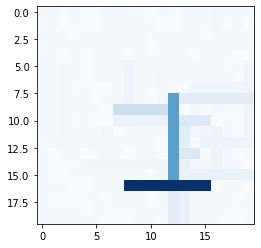

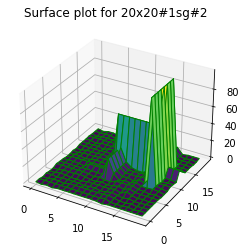

Run: 1
Team: 78ade838-a7a2-4d7f-9fc9-45ea17f856c9
? ? X ? X X ↓ ↓ ↓ X X ? X ↓ ↓ ← ↓ ← ↓ ← 

X ? X ? X X → → ↓ ↓ ← X X ↓ ↓ ← ↓ X ↓ X 

? ? ? X → → → → → → → ↓ ← ← ↓ X ↓ ↓ ↓ ← 

X → → → → ↓ ↑ ↑ → ↓ X ↓ → → → ↓ ↓ ← ← ← 

? ? X ? X ↓ ↑ ↑ X → ↓ ↓ ← ← X ↓ ↓ ↑ X X 

? ? ? ? X → → → → → → ↓ → → → ↓ ↓ X ? ? 

? ? ? ? X → → → → → → ↓ → → → ↓ ↓ ← X ? 

? ? ? X ? X X ↑ ↓ ↑ ↓ ↓ X X ← ↓ ← ← ← ← 

? ? ? ? ? X ? ↑ ↓ ↑ X → ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → → → → ↓ X ? X ↑ X X ? 

? ? ? X ? X X → → ↑ ↑ ↑ ↓ ← ← ↓ X ↓ X ? 

? ? ? ? ? ↓ ? X → → ↑ → ↓ → → ↓ ← ↓ X ? 

X ? ? ? ? ↓ ? ? ↓ ↑ ↑ X ↓ ? X → → ↓ ← ← 

? X ? ? X ↓ ? ? X ↑ ↑ X ↓ ? ? X ↓ ↓ X ? 

? X X X ← ↓ ← ← ← ↑ ↑ ← ↓ ← ← ↓ ← ← ← X 

? X X → → → → → → ↑ X → → → → ↓ ↓ ↑ ← ← 

? ? ? X X ↑ ? ? ← ← ← ← ← ← ← ← X ↑ ? X 

? X X X ? ↑ X ? ? ↑ X ? ↑ ? ? ↓ ? ↑ X ? 

? ? ? ? X → → → → ↑ → → ↑ → → → → ↑ ← ← 

← ← ← ← ← ↑ X X X ↑ ↑ X ↑ ? ? ↓ ? X X ? 



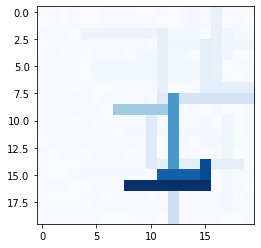

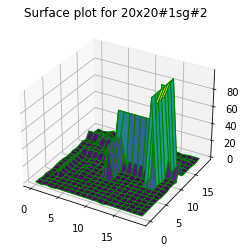

Run: 2
Team: 6690e471-74fb-4a88-aad2-a0e1b60bd650
? ? X ? X X ? ↓ ? X X ? X ↓ ↓ ? ↓ ? ? ? 

X ? X ? X X ? ↓ ? ↓ ↓ X X ↓ ← ← ← X ? X 

? ? ? X → → → → → → → ↓ ↓ ↓ ↑ X → → ← ← 

X ? ? ? ? ? ? ↑ ? ↓ X → → → ↑ ↓ ← ← ← ← 

? ? X ? X ? ? ↑ X ↓ ↓ ↓ ↓ ↓ X ↓ ↑ ← X X 

? ? ? ? X ← ← ↑ ↓ ← ↓ ↓ ← ← ← ↓ ↑ X ? ? 

? ? ? ? X → → → → → → ↓ → → → ↓ ↑ ← X ? 

? ? ? X ? X X → → → → ↓ X X ? ↓ ↑ ? ↓ ? 

? ? ? ? ? X ← ↑ ↓ ↓ X → ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X → → → → ↓ ↓ X ? X ↑ X X ? 

? ? ? X ? X X → → → ← ← ↓ ← ← ← X ? X ? 

? ? ? ? ? ? ? X ↑ ↑ ↓ ↑ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ↑ ↑ ↓ X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ↑ ← X ↓ ? ? X ? ? X ? 

? X X X ? ? ? ? ? ↑ ↓ ? ↓ ? ? ? ? ? ? X 

? X X ? ? ? ? ? ? ↑ X ? ↓ ? ? ? ? ? ? ? 

? ? ? X X ? ? ? ↑ ↑ ? ? ↓ ? ? ? X ? ? X 

? X X X ? ? X ? ↑ ↑ X ? ↓ ? ? ? ? ? X ? 

? ? ? ? X ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ↓ ? ? ? ? X X ? 



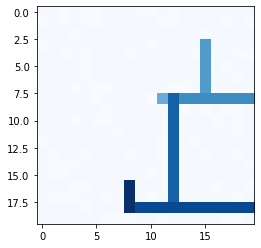

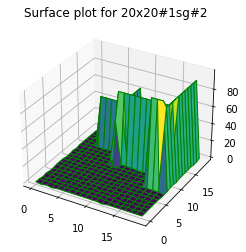

Run: 3
Team: 548a465a-2bac-4eba-8784-76e7561ef31b
? ↓ X ? X X ? ? ? X X ? X ? ? ? ↓ ? ? ? 

X ↓ X ? X X ? ? ? ↓ ? X X ? ? ? ↓ X ? X 

→ → ↓ X ← ← ← ← ← ↓ ← ↓ ← ← ← X ↓ ? ? ? 

X → → → → → → → → ↓ X ↓ ↑ ? ? ? ↓ ? ? ? 

? ↑ X ? X ↑ ? ? X ↓ → ↓ ↑ ← X → ↓ ← X X 

← ↑ ← ← X ↑ ← ← ↓ ↓ ← ← ← ← ← ← ↓ X ? ? 

? ↑ ↑ ? X ↑ ← ← ← ↓ ← ← ← ← ← ← ↓ ← X ? 

? ↑ ↑ X ↓ X X ? ↓ ↓ ? ↑ X X ↓ ? ↓ ? ↓ ? 

? ↑ ↑ ↓ ↓ X ? ? ↓ ↓ X → ↓ ← ← ← ← ← ← ← 

→ ↑ → ← ← ← X ← ← ↓ ← ↑ ↓ X ↓ X ↓ X X ? 

? ↑ ↑ X ↓ X X ? ↓ ↓ ↓ ↑ ↓ ↓ ↓ ? X ? X ? 

← ↑ ↑ ← ↓ ← ← X → → → → ↓ ↓ ↓ ← ← ← X ? 

X ↑ → → → ↑ ← ← ← ↓ ↑ X ↓ ↓ X ? ? ? ? ? 

? X ↑ ? X ↑ ? ? X → ↑ X ↓ ← ← X ? ? X ? 

? X X X ↓ ← ← ← ← ← ← ← ← ← ← ← ← ← ← X 

? X X → → → → → ↓ ↑ X ? ↑ ↑ ? ? ? ? ? ? 

? ? ? X X ↑ ? ? ↓ ↑ ? ? ↑ ↑ ? ? X ? ? X 

? X X X ? ↑ X ? ? ↑ X ? ↑ ↑ ? ? ? ? X ? 

? ? ? ? X → → → → ↑ ↓ ← ↑ ↑ ← ← ← ← ← ← 

? ? ? ? ? ↑ X X X ↑ ← X ↑ ↑ ← ← ← X X ? 



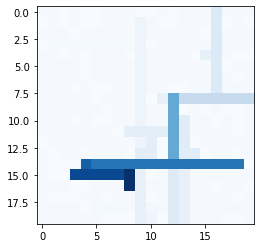

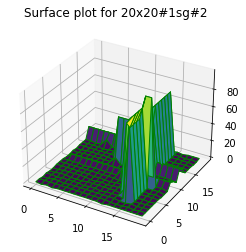

Run: 5
Team: ede17689-3e16-4bcf-9dfe-e04fff08c162
← ↓ X ? X X → ↓ ↓ X X ? X ↓ ↓ ↓ ↓ ? ? ? 

X ↓ X ? X X ↓ ↓ ← ↓ ← X X ↓ ↓ ← ↓ X ? X 

← ↓ ← X → ↓ ↓ ↓ → ↓ ↑ ↓ ↓ ← ← X ↓ → → ↓ 

X → → → → → → ↓ ← ↓ X ↓ ↓ ← ← ← ← ← ← ← 

↓ ↑ X ↓ X → → ↓ X ↓ ← ← ← ← X ↑ ↓ ← X X 

↓ ↑ ↓ ← X → → → → ↓ ← ↓ ← ← ← ← ← X ← ↓ 

↓ ↑ ↓ ← X → → ↑ → ↓ → ↓ ← ← ← ← ← ← X ↓ 

→ ↑ ↓ X ↓ X X ↑ ← ↓ ← ↓ X X ↑ ↑ ← ← ← ← 

→ → → → ↓ X ? ↑ ↓ ↓ X ↓ ← ← ← ← ← ← ← ← 

↑ ↑ ↑ ← ↓ ← X ↑ ↓ ↓ ? ↓ ? X ↑ X ↑ X X ↑ 

↑ ↑ ↑ X ↓ X X ↑ ← ↓ ← ↓ ← ← ↑ ↓ X ? X ↑ 

→ → → → ↓ → ↓ X → ↓ ← ← ← ← ← ← ← ← X ↑ 

X → → → → → → → → ↓ ← X ? ? X → ↑ ← ← ← 

? X ↑ ← X ? ↓ ? X ↓ ? X ? ? ? X ↑ ← X ↑ 

? X X X ? ? ↓ ? ? ↓ ? ? ? ? ? ? ↑ ? ? X 

? X X ? ? ? ↓ ? ? ↓ X ? ? ? ? ? ↑ ? ? ? 

? ? ? X X ? ↓ ? ↑ ↓ ? ? ? ? ? ? X ? ? X 

? X X X ? ? X ? ↑ ↓ X ? ? ? ? ? ? ? X ? 

? ? ? ? X ← ← ← ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ? X ? ? ? ? ? X X ? 



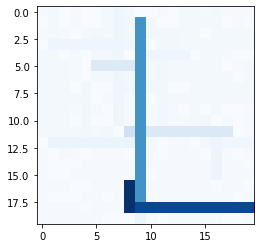

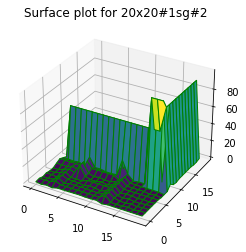

Run: 6
Team: da3f457b-b774-4dfc-9185-4c3072caaefd
? ? X ? X X ↓ ← ← X X ? X ↓ ← ↓ ← ← ← ← 

X ? X ? X X ↓ ↑ ? ? ? X X ↓ ← ← ← X ? X 

? ? ? X ← ← ↓ ↑ ← ← ← ← ← ↓ ← X ↑ ? ? ? 

X ? ? ? ? ? ↓ ↑ ? ? X ? ? ↓ ? ? ↑ ? ? ? 

? ? X ? X ? ↓ ↑ X ? ? ? ? ↓ X → ↑ ← X X 

? ? ? ? X ← ↓ ↑ ← ← ← ← ← ← ↓ ← ← X ? ? 

? ? ? ? X → → → → → → → → → ↓ ← ↑ ← X ? 

? ? ? X ? X X ↑ ? ? ? ? X X ↓ ? ↑ ? ? ? 

? ? ? ? ? X ? ↑ ? ? X ? ? ? ↓ ? ↑ ? ? ? 

? ? ? ? ? ? X ↑ ? ? ? ? ? X ↓ X ↑ X X ? 

? ? ? X ? X X ↑ ? ? ? ? ? ↓ ↓ ? X ? X ? 

? ? ? ? ? ? ? X ← ← ← ← ← ↓ ← ← ← ← X ? 

X ? ? ? ? ? ? ? ? ? ? X ? ↓ X ? ? ? ? ? 

? X ? ? X ? ? ? X ? ? X ? ↓ ↓ X ? ? X ? 

? X X X → → → → ↓ ← ← ← ← ← ← ← ← ← ← X 

? X X ? ↓ ? ? ? ↓ ? X ? ? ↓ ↑ ? ? ? ? ? 

? ? ? X X ? ? ? ↓ ? ? ? ? ↓ ↑ ? X ? ? X 

? X X X ? ? X ? ? ? X ? ? ↓ ↑ ? ? ? X ? 

? ? ? ? X ? ? ? ? ? ? ? ? ↓ ↑ ? ? ? ? ? 

? ? ? ? ? ? X X X ? ? X → → ↑ ← ← X X ? 



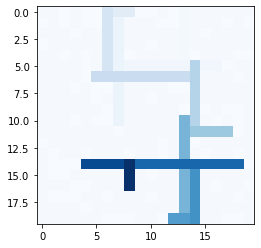

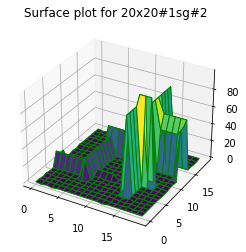

Run: 7
Team: 74e41c5b-0512-4d21-96a5-ab07f0f63826
? ? X ? X X ? ? ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ? ? ↓ ? X X ? ? ? ↓ X ? X 

? ? ? X ? ? ? ? ? ↓ ? ? ? ? ? X ↓ ? ? ? 

X ? ? ? ? ? ? ? ? ↓ X ? ? ? ? ↓ ↓ ? ? ? 

? ? X ? X ? ? ? X ↓ ? ? ? ? X → ↓ ← X X 

? ? ? ? X ? ? ? ? ↓ ? ? ? ? ? ↓ ↓ X ? ? 

? ? ? ? X → → → → ↓ → → → → → → → ← X ? 

? ? ? X ? X X ? ? ↓ ? ? X X ? ↓ ↓ ↓ ? ? 

? ? ? ? ? X ? ? ? ↓ X ? ↓ ? ? ↓ ↓ ↓ ? ? 

? ? ? ? ? ? X ? ? ↓ ? ? ↓ X ? X ↓ X X ? 

? ? ? X ? X X ← ← ↓ ← ← ↓ ↓ ← ← X ↓ X ? 

? ? ? ? ? ? ? X ← ↓ ← ← ↓ ↓ ← ← ← ↓ X ? 

X ? ? ? ? ? ? ? ? ↓ ? X ↓ ↓ X ? ↑ ↓ ? ? 

? X ? ? X ? ? ? X ↓ ? X ↓ ↓ ? X ↑ ↓ X ? 

? X X X → → → → → ↓ → → ↓ ↓ → → ↑ ↓ ← X 

? X X ? ? ? ? ? ? ↓ X ? ↓ ↓ ? ? ↑ ↓ ? ? 

? ? ? X X ? ? ? ↑ ↓ ? ? ↓ ↓ ? ? X ↓ ← X 

? X X X ? ? X ? ↑ ↓ X → → ↓ → → ↓ ← X ↓ 

? ? ? ? X → → → ↑ ← ← ← ← ← ← ← ← ← ← ← 

? ? ? ? ? ? X X X ↑ ← X → → → → ↑ X X ↓ 



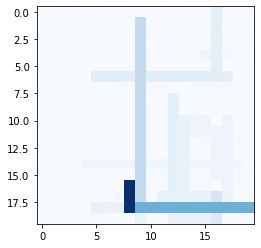

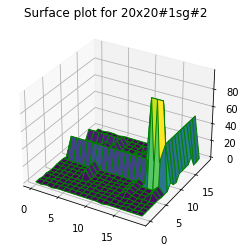

Run: 8
Team: 3d68a65d-1ec6-4aa5-8438-e87b6d520480
? ? X ? X X ? ? ? X X ? X ? ? ? ↓ ? ? ? 

X ? X ? X X ? ? ? ? ? X X ? ? ? ↓ X ? X 

? ? ? X ? ? ? ? ? ? ? ? ? ? ? X ↓ ← ← ↓ 

X ? ? ? ? ? ? ? ? ? X → → → → → ↓ ← ← ← 

? ? X ? X ? ? ? X ? ? ? ? ? X ↑ ↓ ← X X 

? ? ? ? X ? ? ? ? ? ? ? ? ? ? ↑ ↓ X ? ? 

? ? ? ? X → → → → → → → → → → → → ↓ X ? 

? ? ? X ? X X ? ? ? ? ? X X ? ↑ ↓ ↓ ? ? 

? ? ? ? ? X ? ? ? ? X ← ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X ? ? ? ? ? ↓ X ? X ↓ X X ? 

? ? ? X ? X X ? ? ? ? ? ↓ ? ? ? X ↓ X ? 

? ? ? ? ? ? ? X ? ? ? ? ↓ ? ? ? ↓ ↓ X ? 

X ? ? ? ? ? ? ? ? ? ? X ↓ ← X ? ↓ ↓ ? ? 

? X ? ? X ? ? ? X ? ? X ↓ ← ← X ↓ ← X ? 

? X X X ↓ ← ← ← ↓ ← ← ← ← ← ← ← ← ← ← X 

? X X → → → → → ↓ ← X → → → → → → ↑ ↓ ← 

? ? ? X X ? ? ? ↓ ? ? ? ↑ ? ? ? X ↑ ← X 

? X X X ? ? X ? ? ? X ? ↑ ? ? ? ? ↑ X ? 

? ? ? ? X ? ? ? ? ? ? ? ↑ ? ? ? ? ↑ ? ? 

? ? ? ? ? ? X X X ? ? X ↑ ? ? ? ? X X ? 



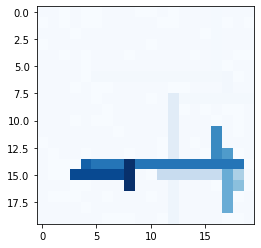

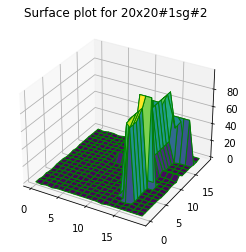

Run: 9
Team: 8b173c37-6ca4-47a2-bf70-f4a74bb6f7e7
? ? X ? X X ? ↓ ↓ X X ? X ↓ ↓ ← ← ← ↓ ← 

X ? X ? X X ? ↓ ↓ ? ↓ X X ↓ ↓ ↑ ↓ X ↓ X 

? ? ? X → → → → → → → ↓ ← ↓ ↓ X → ↓ ↓ ↓ 

X ? ? ? ↓ ? ? ↓ ↓ ? X ↓ → → → ↓ ← ← ← ← 

? ? X ? X ? ? ↓ X ? ? ↓ ↑ ↓ X ↓ → ↑ X X 

? ? ? ? X → → → → → → ↓ → → → ↓ ← X ? ? 

? ? ? ? X → → → → → → ↓ ← ← ← ↑ ← ← X ? 

? ? ? X ? X X ↑ ← ← ← ↓ X X ? ↑ ↑ ↓ ? ? 

? ? ? ? ? X ? ↑ ? ? X → ↓ ← ← ← ← ← ← ← 

? ? ? ? ? ? X ↑ ? ? ? ↑ ↓ X ? X ↑ X X ? 

? ? ? X ? X X ↑ ? ? ? ↑ ↓ ? ? ? X ? X ? 

? ? ? ? ? ? ? X ? ? ? ↑ ↓ ? ? ? ? ? X ? 

X ? ? ? ? ? ? ? ? ? ? X ↓ ? X ? ? ? ? ? 

? X ? ? X ? ? ? X ? ? X ↓ ? ↓ X ? ? X ? 

? X X X ? ? ? ? ? ? ? ? ↓ ? ↓ ↓ ? ? ? X 

? X X ? ? ? ? ? ? ? X ? ↓ ? ↓ ↓ ? ? ? ? 

? ? ? X X ? ? ? ← ← ← ← ← ← ← ← X ? ? X 

? X X X ? ? X ? ? ? X ? ↓ ? ↓ ↑ ↓ ? X ? 

? ? ? ? X ← ← ← ← ← ← ← ↓ ← ↓ ↑ ← ← ← ← 

? ? ? ? ? ? X X X ? ? X → → → ↑ ← X X ? 



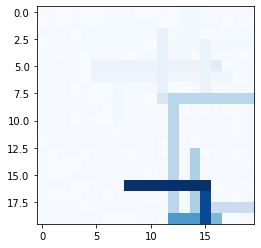

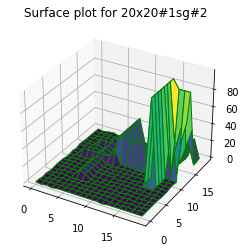

In [17]:
# importing libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

for run in range(runs):
    for team in run_winners[run]['winners']:

        print(f'Run: {run}')
        print(f'Team: {team.id}')
        
        region_action_scores = []
        for learner in team.learners:
            if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
                region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
            else:
                region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

        sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
        # print(sorted_region_action_scores)
        # for record in sorted_region_action_scores:
        #     print(record)
        action_states = []
        for record in sorted_region_action_scores:
            action = ''
            if record['action'] == 0:
                action = '\u2191'
            elif record['action'] == 1:
                action = '\u2193'
            elif record['action'] == 2:
                action = '\u2192'
            elif record['action'] == 3:
                action = '\u2190'

            for i in range(record['region'][3] - record['region'][2]+1):
                state = [0, 0]
                state[record['region'][0]] = record['region'][1]
                state[not record['region'][0]] = record['region'][2] + i

                # ensure we do not enter duplicate states
                found = 0
                for pair in action_states:
                    if pair['state'] == (state[0], state[1]):
                        found = 1

                if found == 0:
                    action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

        # add in the rest of the states, either they are not visited, or illegal
        for n in reversed(range(env.rows)):
            for m in range(env.cols):
                action = ''
                found = 0
                for record in action_states:
                    if record['state'] == (n, m):
                        found = 1
                        action = record['action']
        #                 action = float(round(record['q'], 0))
                if found == 0:
                    if not env.check_legal((n, m)):
                        action = 'X'
                    else:
                        action = '?'
                print(f'{action} ', end='')
            print('\n')


        q_map = np.zeros((env.rows, env.cols))

        # add in the rest of the states, either they are not visited, or illegal
        for n in range(env.rows):
            for m in range(env.cols):
                action = ''
                found = 0
                for record in action_states:
                    if record['state'] == (n, m):
                        found = 1
                        action = record['q']
                if found == 0:
                    if not env.check_legal((n, m)):
                        action = -1
                    else:
                        action = 0
                q_map[(env.rows-1)-n][m] = action

        plt.imshow(q_map, cmap='Blues', interpolation='nearest')
        plt.show()

        x = []
        y = []
        for i in range(env.cols):
            x.append(i)
            y.append(i)

        Y, X = np.meshgrid(x, y)

        fig = plt.figure()

        # syntax for 3-D plotting
        ax = plt.axes(projection ='3d')

        # syntax for plotting
        ax.plot_surface(X, Y, q_map, cmap ='viridis', edgecolor ='green')
        ax.set_title(f'Surface plot for {envName}')
        plt.show()

## Heatmap (RL)

In [18]:
for run in range(runs):
    for team in run_winners[run]['winners']:

        print(f'Run: {run}')
        print(f'Team: {team.id}')
        
        region_action_scores = []
        for learner in team.learners:
            if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
                region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
            else:
                region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

        sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)

        state_counts = []

        for n in reversed(range(env.rows)):
            for m in range(env.cols):
                state_count = 0
                for record in sorted_region_action_scores:
                    for i in range(record['region'][3] - record['region'][2]+1):
                        state = [0, 0]
                        state[record['region'][0]] = record['region'][1]
                        state[not record['region'][0]] = record['region'][2] + i

                        if state == [n, m]:
                            state_count += 1
                        # state count logic goes here
                state_counts.append({'state': (n, m), 'count': state_count})

        for n in reversed(range(env.rows)):
            for m in range(env.cols):
                for record in state_counts:
                    if (n, m) == record['state']:
                        count = record['count']
                        print(f'{count} ', end='')
            print('')

Run: 0
Team: 06462ee4-29c4-44c9-8ba7-77b90fd9cc89
0 4 0 0 0 0 4 3 1 0 0 0 0 6 5 4 8 5 5 5 
0 4 0 0 0 0 4 4 1 4 1 0 0 4 3 3 6 0 1 0 
0 4 0 0 4 4 8 5 4 7 4 5 5 6 5 0 4 1 2 1 
0 4 0 2 0 1 4 3 0 4 0 7 4 5 6 7 7 4 4 4 
1 4 0 2 0 2 4 3 0 4 1 3 2 2 0 5 5 1 0 0 
1 4 8 2 0 5 6 7 4 7 5 6 6 5 7 8 8 0 1 4 
5 7 10 3 0 5 6 7 6 9 5 8 6 6 9 8 9 7 0 5 
2 5 7 0 2 0 0 4 2 4 1 4 0 0 9 12 8 7 7 9 
3 5 9 2 3 0 1 3 2 4 0 14 13 12 12 13 14 12 12 14 
3 7 9 3 3 3 0 6 3 7 3 4 6 0 4 0 4 0 0 5 
7 5 7 0 2 0 0 7 5 8 4 7 7 5 7 4 0 0 0 5 
1 4 8 0 2 0 1 0 1 4 1 3 5 4 4 1 1 0 0 5 
0 6 9 2 3 2 2 3 3 6 3 0 5 4 0 2 2 2 2 5 
0 0 8 0 0 0 1 2 0 4 1 0 5 4 1 0 1 0 0 5 
0 0 0 0 3 2 2 3 2 5 3 3 7 5 2 2 3 2 2 0 
0 0 0 2 1 2 3 3 2 5 0 1 7 5 2 2 2 2 2 2 
0 0 0 0 0 0 1 2 1 5 1 2 5 5 1 1 0 0 0 0 
0 0 0 0 0 0 0 2 1 4 0 1 5 4 0 0 0 0 0 0 
0 0 0 0 0 0 0 2 0 4 0 1 5 4 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 4 0 0 6 3 1 1 1 0 0 0 
Run: 1
Team: 78ade838-a7a2-4d7f-9fc9-45ea17f856c9
0 0 0 0 0 0 2 3 1 0 0 0 0 3 3 1 6 1 1 1 
0 0 0 0 0 0 4 4 3 7 2 0 0 3 

In [19]:
# print(team.gp_query_env)
# print(gp_query_env)
query_average = 0
for query_total in gp_query_runs:
    query_average += query_total
    print(query_total)
    
query_average /= len(gp_query_runs)
print(f'Average query total: {query_average}')

1344
769
342
478
1238
1260
175
399
165
535
Average query total: 670.5
